In [30]:
%matplotlib inline

# analysis per system

import sys
# sys.path.append('/home/anna/Documents/code/python/pipeline')

# import libraries
import seaborn as sns
import numpy as np
import scipy.stats as _stats
from scipy.interpolate import griddata
from functools import reduce
from pipeline.analysis import *
from pipeline.utils import *
from pipeline import *
import logging
import networkx as nx
import glob
from scipy.stats import sem as sem
from matplotlib import colormaps
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

from matplotlib.ticker import MaxNLocator

import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)
# warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)

logging.getLogger().setLevel(logging.INFO)

from cinnabar import wrangle as _wrangle


print(BSS.__file__)

/home/anna/BioSimSpace/python/BioSimSpace/__init__.py


In [31]:
def check_normal_dist(values):
    # check normally dist
    if len(values) < 50:
        stat, p = _stats.shapiro(values)
    else:
        stat, p = _stats.kstest(values)
    if p < 0.05:
        return True
    else:
        return False


def flatten_comprehension(matrix):
    return [item for row in matrix for item in row]

In [32]:
# define the analysis method to use
ana_dicts = {
    "plain": {
        "estimator": "MBAR",
        "method": "alchemlyb",
        "check overlap": True,
        "try pickle": True,
        "save pickle": True,
        "auto equilibration": False,
        "statistical inefficiency": False,
        "truncate lower": 0,
        "truncate upper": 100,
        "name": None,
    },
    "subsampling": {
        "estimator": "MBAR",
        "method": "alchemlyb",
        "check overlap": True,
        "try pickle": True,
        "save pickle": True,
        "auto equilibration": False,
        "statistical inefficiency": True,
        "truncate lower": 0,
        "truncate upper": 100,
        "name": None,
    },
    "1ns": {
        "estimator": "MBAR",
        "method": "alchemlyb",
        "check overlap": True,
        "try pickle": True,
        "save pickle": True,
        "auto equilibration": False,
        "statistical inefficiency": False,
        "truncate lower": 0,
        "truncate upper": 25,
        "name": None,
    },
    "2ns": {
        "estimator": "MBAR",
        "method": "alchemlyb",
        "check overlap": True,
        "try pickle": True,
        "save pickle": True,
        "auto equilibration": False,
        "statistical inefficiency": False,
        "truncate lower": 0,
        "truncate upper": 50,
        "name": None,
    },
    "3ns": {
        "estimator": "MBAR",
        "method": "alchemlyb",
        "check overlap": True,
        "try pickle": True,
        "save pickle": True,
        "auto equilibration": False,
        "statistical inefficiency": False,
        "truncate lower": 0,
        "truncate upper": 75,
        "name": None,
    },
    "autoeq": {
        "estimator": "MBAR",
        "method": "alchemlyb",
        "check overlap": True,
        "try pickle": True,
        "save pickle": True,
        "auto equilibration": True,
        "statistical inefficiency": True,
        "truncate lower": 0,
        "truncate upper": 100,
        "name": None,
    },
    # "TI": {
    # "estimator": "TI",
    # "method": "alchemlyb",
    # "check overlap": True,
    # "try pickle": True,
    # "save pickle": True,
    # "auto equilibration": False,
    # "statistical inefficiency": False,
    # "truncate lower": 0,
    # "truncate upper": 100,
    # "name": None,
    # },
    #     "single_0": {
    #     "estimator": "MBAR",
    #     "method": "alchemlyb",
    #     "check overlap": True,
    #     "try pickle": True,
    #     "save pickle": True,
    #     "auto equilibration": False,
    #     "statistical inefficiency": False,
    #     "truncate lower": 0,
    #     "truncate upper": 100,
    #     "name": None,
    # },
    #     "single_1": {
    #     "estimator": "MBAR",
    #     "method": "alchemlyb",
    #     "check overlap": True,
    #     "try pickle": True,
    #     "save pickle": True,
    #     "auto equilibration": False,
    #     "statistical inefficiency": False,
    #     "truncate lower": 0,
    #     "truncate upper": 100,
    #     "name": None,
    # },
    #     "single_2": {
    #     "estimator": "MBAR",
    #     "method": "alchemlyb",
    #     "check overlap": True,
    #     "try pickle": True,
    #     "save pickle": True,
    #     "auto equilibration": False,
    #     "statistical inefficiency": False,
    #     "truncate lower": 0,
    #     "truncate upper": 100,
    #     "name": None,
    # }
}

In [33]:
prot_dict_name = {
    "tyk2": "TYK2",
    "mcl1": "MCL1",
    "p38": "P38α",
    "syk": "SYK",
    "hif2a": "HIF2A",
    "cmet": "CMET",
}
eng_dict_name = {"AMBER": "AMBER22", "SOMD": "SOMD1", "GROMACS": "GROMACS23", "hahn": "Hahn et al.", "openfe": "OpenFE", "fepplus": "FEP+"}

set_cols = pipeline.analysis.set_colours(other_results_names=["hahn","openfe","fepplus"])
col_dict = {}
for eng in eng_dict_name:
    col_dict[eng_dict_name[eng]] = set_cols[eng]

In [34]:
protein = "tyk2"

In [35]:
network_dict = {}

# 
# , "combined", "lomap", "rbfenn", "flare", "lomap-a-optimal", "lomap-d-optimal", "rbfenn-a-optimal", "rbfenn-d-optimal"
for network in ["combined", "lomap", "rbfenn", "flare"]:
    # all the options
    ana_obj_dict = {}

    for ana_dict in ana_dicts.items():
        ana_prot = analysis_protocol(ana_dict[1])

        bench_folder = f"/home/anna/Documents/benchmark"
        # main_dir = f"{bench_folder}/reruns/{protein}"
        main_dir = f"/backup/{protein}"

        # # if need size of protein
        # try:
        #     prot = BSS.IO.readMolecules(
        #         [
        #             f"{bench_folder}/inputs/{protein}/{protein}_prep/{protein}.gro",
        #             f"{bench_folder}/inputs/{protein}/{protein}_prep/{protein}.top",
        #         ]
        #     )[0]
        # except:
        #     prot = BSS.IO.readMolecules(
        #         [
        #             f"{bench_folder}/inputs/{protein}/{protein}_parameterised.prm7",
        #             f"{bench_folder}/inputs/{protein}/{protein}_parameterised.rst7",
        #         ]
        #     )[0]

        # print(f"no of residues in the protein: {prot.nResidues()}")

        # choose location for the files
        if protein == "syk" or protein == "cmet" or protein == "hif2a":
            # the lomap network
            if network == "lomap":
                net_file = f"{main_dir}/execution_model/network_lomap.dat"
            else:
                ana_obj_dict[protein][ana_dict[0]] = None
                continue
        elif protein == "p38":
            if network == "lomap-a-optimal" or network == "lomap-d-optimal" or network == "rbfenn-a-optimal" or network == "rbfenn-d-optimal":
                ana_obj_dict[protein][ana_dict[0]] = None
                continue
            else:
                net_file = f"{main_dir}/execution_model/network_{network}.dat"

        else:
            net_file = f"{main_dir}/execution_model/network_{network}.dat"

        exp_file = f"{bench_folder}/inputs/experimental/{protein}.yml"
        output_folder = f"{main_dir}/outputs_extracted"

        # prot_file = f"{main_dir}/execution_model/protocol.dat" # no protocol used , name added after if needed
        pipeline_prot = pipeline_protocol(auto_validate=True)
        # pipeline_prot.name("")

        # initialise the network object
        all_analysis_object = analysis_network(
            output_folder,
            exp_file=exp_file,
            net_file=net_file,
            analysis_prot=ana_prot,
            # method=pipeline_prot.name(),  # if the protocol had a name
            # engines=pipeline_prot.engines(),
        )

        # compute
        try:
            all_analysis_object.compute_results()
        except:
            print("failed analysis")

        # add ligands folder
        all_analysis_object.add_ligands_folder(
            f"{bench_folder}/inputs/reruns/{protein}/ligands_intermediates"
        )
        
        ana_obj_dict[ana_dict[0]] = all_analysis_object

    network_dict[network] = ana_obj_dict

ERROR:root:'file_path' must be of type 'str'.
ERROR:root:Not recognised as file, trying to read as dictionary...
INFO:root:mbar method not found in protocol. None will be used.
INFO:root:no file or dict passed, using entirely default values...
INFO:root:'hmr' must be set to True for a hmr factor to be applied. It will still be set as auto.
ERROR:root:'file_path' must be of type 'str'.
ERROR:root:Not recognised as file, trying to read as dictionary...
ERROR:root:<pipeline.prep._protocol.analysis_protocol object at 0x764e3b6e47c0> / 'dictionary' must be of type 'dict'.
ERROR:root:dictionary wasn't recognised either. trying to read as pipeline protocol...
INFO:root:no output folder provided, writing all output to the 'output_folder/analysis'.
ERROR:root:'Intermediate'
ERROR:root:the experimental pert value for Intermediate~lig_ejm49 could not be computed and will be left empty. Is the ligand in the experimental file?
ERROR:root:'Intermediate'
ERROR:root:the experimental pert value for Int

In [7]:
# set the network for the pertubation analysis
network = "combined"
ana_obj = network_dict[network]["plain"]


In [ ]:
# identify any outliers and plot again if needed above
failed_perts_dict_percen = {}
failed_perts_dict = {}

failed_perts_dict_percen = {}
failed_perts_dict = {}

for eng in ana_obj.engines:  # ana_obj.engines
    failed_perts_dict_percen[eng] = (
        100 - ana_obj.successful_perturbations(eng)[1]
    )
    failed_perts_dict[eng] = ana_obj.failed_perturbations(eng)
    print(
        f"failed percentage for {eng}: {100 - ana_obj.successful_perturbations(eng)[1]} ({len(ana_obj.perturbations) - len(ana_obj.successful_perturbations(eng)[2])} / {len(ana_obj.perturbations)})"
    )
    print(f"{eng} failed perturbations: {ana_obj.failed_perturbations(engine=eng)}")
    print(f"{eng} disconnected ligands: {ana_obj.disconnected_ligands(engine=eng)}")
    print(f"outliers 10 {eng}: {ana_obj.get_outliers(threshold=10, name=eng)}")
    print(f"outliers 5 {eng}: {ana_obj.get_outliers(threshold=5, name=eng)}")

    # ana_obj.remove_outliers(threshold=5, name=eng)

In [ ]:
ana_obj.check_convergence(compute_missing=False)

In [ ]:
# get the perturbations that are 'well' converged

splitby = "all"

for eng in ana_obj.engines:
    con_perts =[]
    noncon_perts = []
    for pert in ana_obj.convergence_dict[eng]:
        if splitby == "all":
            con_arr = np.array([val for val in ana_obj.convergence_dict[eng][pert].values()])
        if splitby == "free":
            con_arr = np.array([ana_obj.convergence_dict[eng][pert][key] for key in ana_obj.convergence_dict[eng][pert] if "free" in key])
        if splitby == "bound":
            con_arr = np.array([ana_obj.convergence_dict[eng][pert][key] for key in ana_obj.convergence_dict[eng][pert] if "bound" in key])

        con_arr = [c for c in con_arr if c]
        print(con_arr)
        # con_arr = con_arr[~np.isnan(con_arr)]
        mean = np.mean(con_arr)
        if mean > 0.75:
            con_perts.append(pert)
        else:
            noncon_perts.append(pert)

    con_vals = [ana_obj.calc_pert_dict[eng][pert][0] -ana_obj.exper_pert_dict[pert][0] for pert in con_perts]
    noncon_vals = [ana_obj.calc_pert_dict[eng][pert][0] -ana_obj.exper_pert_dict[pert][0] for pert in noncon_perts]
    all_vals = [ana_obj.calc_pert_dict[eng][pert][0]  -ana_obj.exper_pert_dict[pert][0] for pert in ana_obj.convergence_dict[eng]]
    print(len(con_vals),len(noncon_vals), len(all_vals))

    plt.figure(figsize=(6, 6))
    plt.hist(con_vals, density=True, color="magenta", label="Converged", alpha=0.5)
    plt.hist(noncon_vals, density=True, color="plum", label="Non-converged", alpha=0.5)
    plt.hist(all_vals, density=True, color="darkblue", label="All", alpha=0.5)
    plt.legend(loc="upper right")
    plt.xlabel(f"MAE (kcal/mol)")
    plt.ylabel(f"Density for {eng}")

In [ ]:
# calculating and plotting the convergence
ana_obj.compute_convergence(compute_missing=False)
ana_obj.plot_convergence()

In [ ]:
# analysis of the perturbation analysis methods

mae_dict = {}

sem_dict = {}
sem_dict_name = {}

for name in ana_dicts:

    sem_list_name = []
    sem_dict[name] = {}

    sem_dict[name][protein] = {}

    ana_obj = network_dict[network][name]

    for eng in ana_obj.engines:
        # print(name, eng)
        sem_dict[name][protein][eng] = {}

        sem_list = []
        sems = [val[1] for val in ana_obj.calc_pert_dict[eng].values()]
        sem_list.append(sems)
        sem_list_name.append(sems)

        sem_list = reduce(lambda xs, ys: xs + ys, sem_list)
        sem_list = [x for x in sem_list if str(x) != "nan"]

        # if not check_normal_dist(sem_list):
        #     print(f"{prot} {name} not normally dist")

        mean = np.mean(sem_list)
        lower_ci, upper_ci = _stats.norm.interval(
            confidence=0.95, loc=np.mean(sem_list), scale=_stats.sem(sem_list)
        )
        # print(protein, name, eng, mean, lower_ci, upper_ci)
        sem_dict[name][protein][eng] = (
            mean,
            _stats.tstd(sem_list),
            (lower_ci, upper_ci),
            sem_list,
        )

    sem_list_name = reduce(lambda xs, ys: xs + ys, sem_list_name)
    sem_list_name = [x for x in sem_list_name if str(x) != "nan"]
    mean = np.mean(sem_list_name)
    lower_ci, upper_ci = _stats.norm.interval(
        confidence=0.95, loc=np.mean(sem_list_name), scale=_stats.sem(sem_list_name)
    )
    # print(name, mean, lower_ci, upper_ci)
    sem_dict_name[name] = (
        mean,
        _stats.tstd(sem_list_name),
        (lower_ci, upper_ci),
        sem_list_name,
    )

    mae_dict[name] = {}

    mae_dict[name][protein] = {}

    ana_obj = network_dict[network][name]

    stats_string_all = ""
    try:
        mae = ana_obj.calc_mae_engines(pert_val="pert", recalculate=True)
    except Exception as e:
        print(e)

    for eng in ana_obj.engines:
        stats_string = ""
        try:
            mae_dict[name][protein][eng] = (
                mae[0][eng]["experimental"],
                mae[1][eng]["experimental"],
                mae[2][eng]["experimental"],
            )
            stats_string += f"{eng} MAE: {mae[0][eng]['experimental']:.2f} +/- {mae[1][eng]['experimental']:.2f} kcal/mol, "

            if sem_dict[name][protein][eng][0]:
                stats_string += f"SEM: {sem_dict[name][protein][eng][0]:.2f} +/- {sem_dict[name][protein][eng][1]:.2f} kcal/mol\n"
            elif name == "single":
                errors = [val[1] for val in ana_obj.calc_pert_dict[eng].values()]
                stats_string += f"error: {np.mean(errors):.2f} +/- {_stats.tstd(errors):.2f} kcal/mol\n"

            # print(stats_string)

        except Exception as e:
            print(e)
            print(f"could not compute for {protein} {name} {eng}")


In [ ]:
# graphs based on engine
plotting_dict = sem_dict  # mae_dict or sem_dict
stats_name = "ΔΔG SEM"  # MAE or SEM

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20, 20), sharex=True, sharey=True)
plt.xlim = ()
plt.ylim = ()
for engine, pos in zip(ana_obj.engines, [axes[0], axes[1], axes[2]]):
    df_list = []
    df_err_list = []
    for name in ana_dicts:
        df = (
            pd.DataFrame(plotting_dict[name])
            .applymap(lambda x: x[0])
            .rename(prot_dict_name, axis=1)
            .T.drop(labels=[eng for eng in ana_obj.engines if eng != engine], axis=1)
            .rename({engine: name}, axis=1)
            .rename(
                {
                    "plain": "Full data",
                    "subsampling": "Subsampling",
                    "autoeq": "Auto-equilibration",
                    "1ns": "1 ns sampling",
                    "2ns": "2 ns sampling",
                    "3ns": "3 ns sampling",
                },
                axis=1,
            )
        )

        df_err = (
            pd.DataFrame(plotting_dict[name])
            .applymap(lambda x: x[1])
            .rename(prot_dict_name, axis=1)
            .T.drop(labels=[eng for eng in ana_obj.engines if eng != engine], axis=1)
            .rename({engine: name}, axis=1)
            .rename(
                {
                    "plain": "Full data",
                    "subsampling": "Subsampling",
                    "autoeq": "Auto-equilibration",
                    "1ns": "1 ns sampling",
                    "2ns": "2 ns sampling",
                    "3ns": "3 ns sampling",
                },
                axis=1,
            )
        )

        # df_lower = df_err.applymap(lambda x: x[0])
        # df_upper = df_err.applymap(lambda x: x[1])
        # df_err = (df_upper - df_lower) / 2

        df_list.append(df)
        df_err_list.append(df_err)

    df = reduce(
        lambda left, right: pd.merge(left, right, left_index=True, right_index=True),
        df_list,
    )
    df_err = reduce(
        lambda left, right: pd.merge(left, right, left_index=True, right_index=True),
        df_err_list,
    )

    print(df)
    print(engine)
    print(df.mean())
    print(df.sem())
    print(df_err)

    # engine colours
    col_dict = {
        "AMBER": plt.get_cmap("autumn"),
        "SOMD": plt.get_cmap("cool"),
        "GROMACS": plt.get_cmap("viridis"),
    }

    # scale data for compatibility with cmap
    data = [i for i in range(1, len(df.columns) + 1)]
    den = max(data) - min(data)
    scaled_data = [(datum - min(data)) / den for datum in data]

    # get colors corresponding to data
    colors = []
    my_cmap = plt.get_cmap("plasma")  # col_dict[engine]

    for decimal in scaled_data:
        colors.append(my_cmap(decimal))

    df.plot(
        kind="bar",
        color=colors,
        yerr=df_err,
        title=eng_dict_name[engine],
        ax=pos,
        xlabel="Protein System",
        ylabel=f"{stats_name} (kcal/mol)",
    )
# fig.suptitle(f'{stats_name} perturbations for LOMAP/RBFENN-score')

In [ ]:
# set the network for the pertubation analysis
network = "combined"
ana_obj = network_dict[network]["plain"]


In [ ]:
# check the statistical significance and make a violin plot

stats_name = "SEM"

# checking for significance 
eng1 = "AMBER"
eng2 = "SOMD"
eng3 = "GROMACS"
first_err_vals = []
second_err_vals = []
third_err_vals = []

if stats_name ==  "MAE":
    # MAE
    f_err_vals = [abs(ana_obj.calc_pert_dict[eng1][key][0]-ana_obj.exper_pert_dict[key][0]) for key in ana_obj.calc_pert_dict[eng1] if not "Intermediate" in key]
    s_err_vals = [abs(ana_obj.calc_pert_dict[eng2][key][0]-ana_obj.exper_pert_dict[key][0]) for key in ana_obj.calc_pert_dict[eng2] if not "Intermediate" in key]
    t_err_vals = [abs(ana_obj.calc_pert_dict[eng3][key][0]-ana_obj.exper_pert_dict[key][0]) for key in ana_obj.calc_pert_dict[eng3] if not "Intermediate" in key]
elif stats_name == "SEM":
    # SEM
    f_err_vals = [abs(ana_obj.calc_pert_dict[eng1][key][1]) for key in ana_obj.calc_pert_dict[eng1]]
    s_err_vals = [abs(ana_obj.calc_pert_dict[eng2][key][1]) for key in ana_obj.calc_pert_dict[eng2]]
    t_err_vals = [abs(ana_obj.calc_pert_dict[eng3][key][1]) for key in ana_obj.calc_pert_dict[eng3]]
else:
    print("wrong name")

first_err_vals.append(f_err_vals)
second_err_vals.append(s_err_vals)
third_err_vals.append(t_err_vals)

first_err_vals = flatten_comprehension(first_err_vals)
second_err_vals = flatten_comprehension(second_err_vals)
third_err_vals = flatten_comprehension(third_err_vals)

# filtered_data = [t for t in zip(first_err_vals, second_err_vals, third_err_vals) if not any(np.isnan(x) for x in t)]
# first_err_vals, second_err_vals, third_err_val = map(list, zip(*filtered_data))
valid_indices = [i for i in range(len(first_err_vals)) if not (np.isnan(first_err_vals[i]) or np.isnan(second_err_vals[i]) or np.isnan(third_err_vals[i]))]
first_err_vals = [first_err_vals[i] for i in valid_indices]
second_err_vals = [second_err_vals[i] for i in valid_indices]
third_err_vals = [third_err_vals[i] for i in valid_indices]

assert len(first_err_vals) == len(second_err_vals)
assert len(first_err_vals) == len(third_err_vals)
assert len(second_err_vals) == len(third_err_vals)

eng_list_dict = {}
eng_list_dict[eng1] = first_err_vals
eng_list_dict[eng2] = second_err_vals
eng_list_dict[eng3] = third_err_vals

stats_test_dict = {}

for enga in [eng1, eng2, eng3]:
    stats_test_dict[enga] = {}
    for engb in [eng1, eng2, eng3]:
        if enga == engb:
            stats_test_dict[enga][engb] = 100
        else:
            # check normally distributed
            if _stats.shapiro(abs(np.array(eng_list_dict[enga] - np.array(eng_list_dict[engb]))))[1] > 0.05:
                print("data is normally distributed !!")
            else:
                t, p = _stats.wilcoxon(eng_list_dict[enga], eng_list_dict[engb]) # absolute error  # ttest_rel
                stats_test_dict[enga][engb] = p
        # print(enga, engb, t, p)

df = pd.DataFrame(stats_test_dict).applymap(lambda x: float(x))
print(f"statistical significance for the {stats_name} for the perturbations between engines")
df

In [ ]:
# MAD between engines

filtered_keys = [
    key for key in ana_obj.calc_pert_dict[eng1]
    if key in ana_obj.calc_pert_dict[eng2] and key in ana_obj.calc_pert_dict[eng3]
    and not (
        np.isnan(ana_obj.calc_pert_dict[eng1][key]).any() or 
        np.isnan(ana_obj.calc_pert_dict[eng2][key]).any() or 
        np.isnan(ana_obj.calc_pert_dict[eng3][key]).any()
    )
]

# statistical sig

# only for the same perturabtions
eng_list_dict = {}
eng_list_dict[eng1] = [ana_obj.calc_pert_dict[eng1][key][0] for key in filtered_keys]
eng_list_dict[eng2] = [ana_obj.calc_pert_dict[eng2][key][0] for key in filtered_keys]
eng_list_dict[eng3] = [ana_obj.calc_pert_dict[eng3][key][0] for key in filtered_keys]

stats_test_dict = {}

for enga in [eng1, eng2, eng3]:
    stats_test_dict[enga] = {}
    for engb in [eng1, eng2, eng3]:
        if enga == engb:
            stats_test_dict[enga][engb] = 100
        else:
            # check normally distributed
            if _stats.shapiro(abs(np.array(eng_list_dict[enga] - np.array(eng_list_dict[engb]))))[1] > 0.05:
                print(f"data is normally distributed for {enga} and {engb}!! Still carrying out wilcoxon signed rank ....")

            t, p = _stats.wilcoxon(eng_list_dict[enga], eng_list_dict[engb]) # absolute error  # ttest_rel
            stats_test_dict[enga][engb] = p
        # print(enga, engb, t, p)

df_col = pd.DataFrame(stats_test_dict).applymap(lambda x: float(x))
print("statistical significance between the perturbations calculated")
df_col

In [ ]:
# compared to each other
mad = ana_obj.calc_mad_engines(pert_val="pert", recalculate=False)
mad[0].update(mad[0].applymap(lambda x: f"" if x == 0 else f"{x:.2f}"))
mad[2].update(mad[2].applymap(lambda x: f"" if x[0] == 0 else f"({x[0]:.2f}, {x[1]:.2f})"))
df_val = mad[0].astype(str) + "\n" + mad[2].astype(str)
df_val

In [ ]:
# plotting the stats test 

# threshold for colour labels
color_labels = df_col.applymap(lambda x: "white" if x == 100 else # same engine, no stats test
                               "grey" if x > 0.05 else # no statistically significant difference
                               "pink") # statistically significant difference

# mapping dictionary
color_mapping = {"pink": "#FFC0CB", "white": "#FFFFFF", "grey": "#BEBEBE"}

# Convert text labels to a numerical array
color_numeric = df_col.applymap(lambda x: 0 if x == 100 else
                                1 if x > 0.05 else
                                2)

# below as otherwise problem if only two colours
array_col_dict = {0: color_mapping["white"],
                  1: color_mapping["grey"],
                  2: color_mapping["pink"]}

numeric_colours_list = flatten_comprehension(color_numeric.values.tolist())

cmap = mcolors.ListedColormap([array_col_dict[key] for key in array_col_dict.keys() if key in numeric_colours_list])

# Plot heatmap using numeric mapping for colors
fig, ax = plt.subplots(figsize=(4,4))
sns.heatmap(color_numeric, annot=df_val, fmt="s", cmap=cmap,
            cbar=False, ax=ax)

legend_patches = [#mpatches.Patch(color=color_mapping["white"], label=""),
                  mpatches.Patch(
                      color=color_mapping["pink"], label="p ≤ 0.05"),
                  mpatches.Patch(color=color_mapping["grey"], label="p > 0.05")]

# Add legend to the plot
plt.legend(handles=legend_patches, loc="center left",
           title="Statistical significance", bbox_to_anchor=(1, 0.5))

plt.title("MAD (kcal/mol) between engines (95% CI)")

In [ ]:
# distribution of the perts values to investigate significant difference if present in the above plot
# histogram
# plt.hist(eng_list_dict[eng1], density=True, color=pipeline.analysis.set_colours()[eng1], label=eng_dict_name[eng1], alpha=0.5)
plt.hist(eng_list_dict[eng2], density=True, color=pipeline.analysis.set_colours()[eng2], label=eng_dict_name[eng2], alpha=0.5)
plt.hist(eng_list_dict[eng3], density=True, color=pipeline.analysis.set_colours()[eng3], label=eng_dict_name[eng3], alpha=0.5)
plt.legend(loc="upper right")
plt.xlabel(f"ddG value (kcal/mol)")
plt.ylabel("Density")
# plt.title(prot_name_dict[protein])

In [ ]:
# violin plots
data = {"engine": [f"{eng_dict_name[eng1]}"]*len(first_err_vals) + [f"{eng_dict_name[eng2]}"]*len(second_err_vals) + [f"{eng_dict_name[eng3]}"]*len(third_err_vals),
        "error": flatten_comprehension([first_err_vals, second_err_vals, third_err_vals])
        }

df = pd.DataFrame(data)

plt.figure(figsize=(8, 5))
sns.violinplot(x="engine", y="error", data=df, inner="box", palette=col_dict)

# plt.title("MAE Distribution for Different MD Engines")
plt.xlabel("MD Engine")
plt.ylabel(f"{stats_name} (kcal/mol)")

In [ ]:
# histogram
plt.hist(first_err_vals, density=True, color=pipeline.analysis.set_colours()[eng1], label=eng_dict_name[eng1], alpha=0.5)
plt.hist(second_err_vals, density=True, color=pipeline.analysis.set_colours()[eng2], label=eng_dict_name[eng2], alpha=0.5)
plt.hist(third_err_vals, density=True, color=pipeline.analysis.set_colours()[eng3], label=eng_dict_name[eng3], alpha=0.5)
plt.legend(loc="upper right")
plt.xlabel(f"ddG {stats_name} (kcal/mol)")
plt.ylabel("Density")
plt.title(prot_name_dict[protein])

In [ ]:
# historgrams of SEM for the legs or repeats

ana_obj.plot_histogram_repeats()
ana_obj.plot_histogram_legs()

# ana_obj.plot_histogram_sem()

In [ ]:
# 2d contour plot
stats_name = "MAE"

for (eng1, eng2) in (["AMBER","SOMD"],["AMBER","GROMACS"],["GROMACS","SOMD"]):

    first_err_vals = []
    second_err_vals = []
    
    filtered_keys = [
        key for key in ana_obj.calc_pert_dict[eng1]
        if key in ana_obj.calc_pert_dict[eng2] #and key in ana_obj.calc_pert_dict[eng3]
        and not (
            np.isnan(ana_obj.calc_pert_dict[eng1][key]).any() or 
            np.isnan(ana_obj.calc_pert_dict[eng2][key]).any() #or 
           # np.isnan(ana_obj.calc_pert_dict[eng3][key]).any()
        )
    ]

    if stats_name == "SEM":
        # MAE
        f_err_vals = [abs(ana_obj.calc_pert_dict[eng1][key][0]-ana_obj.exper_pert_dict[key][0]) for key in filtered_keys if not "Intermediate" in key]
        s_err_vals = [abs(ana_obj.calc_pert_dict[eng2][key][0]-ana_obj.exper_pert_dict[key][0]) for key in filtered_keys if not "Intermediate" in key]

    elif stats_name == "MAE":
        # SEM
        f_err_vals = [abs(ana_obj.calc_pert_dict[eng1][key][1]) for key in filtered_keys]
        s_err_vals = [abs(ana_obj.calc_pert_dict[eng2][key][1]) for key in filtered_keys]

    first_err_vals.append(f_err_vals)
    second_err_vals.append(s_err_vals)

    x = flatten_comprehension(first_err_vals)
    y = flatten_comprehension(second_err_vals)
    z = np.abs(np.array(x) - np.array(y)) #z = np.sin(x) + np.cos(y)

    fig, ax = plt.subplots(figsize=(8, 6))
    sns.kdeplot(x=x, y=y, cmap="PuRd", fill=True, levels=10, thresh=0.05)
    # # Scatter plot on top to show data points
    plt.scatter(x, y, c=z, cmap="Purples", edgecolors="black")
    plt.colorbar(label=f"Absolute difference\n between engine {stats_name} (kcal/mol)")


    # Labels and Title
    plt.xlabel(f"{eng1} {stats_name}")
    plt.ylabel(f"{eng2} {stats_name}")
    plt.title(f"{stats_name}")


In [ ]:
# 2d contour plot
stats_name = "MAE (kcal/mol)"

for eng1,eng2,eng3 in [("GROMACS","SOMD","AMBER"), ("SOMD","AMBER","GROMACS"), ("AMBER","GROMACS","SOMD")]:

    first_err_vals = []
    second_err_vals = []
    third_err_vals = []
        
    filtered_keys = [
        key for key in ana_obj.calc_pert_dict[eng1]
        if key in ana_obj.calc_pert_dict[eng2] and key in ana_obj.calc_pert_dict[eng3]
        and not (
            np.isnan(ana_obj.calc_pert_dict[eng1][key]).any() or 
            np.isnan(ana_obj.calc_pert_dict[eng2][key]).any() or 
            np.isnan(ana_obj.calc_pert_dict[eng3][key]).any()
        )
    ]

    # MAE
    f_err_vals = [abs(ana_obj.calc_pert_dict[eng1][key][0]-ana_obj.exper_pert_dict[key][0]) for key in filtered_keys if not "Intermediate" in key]
    s_err_vals = [abs(ana_obj.calc_pert_dict[eng2][key][0]-ana_obj.exper_pert_dict[key][0]) for key in filtered_keys if not "Intermediate" in key]
    t_err_vals = [abs(ana_obj.calc_pert_dict[eng3][key][0]-ana_obj.exper_pert_dict[key][0]) for key in filtered_keys if not "Intermediate" in key]

    # SEM
    # f_err_vals = [abs(ana_obj.calc_pert_dict[eng1][key][1]) for key in filtered_keys]
    # s_err_vals = [abs(ana_obj.calc_pert_dict[eng2][key][1]) for key in filtered_keys]
    # t_err_vals = [abs(ana_obj.calc_pert_dict[eng3][key][1]) for key in filtered_keys]

    first_err_vals.append(f_err_vals)
    second_err_vals.append(s_err_vals)
    third_err_vals.append(t_err_vals)

    x = np.array(flatten_comprehension(first_err_vals)) - np.array(flatten_comprehension(second_err_vals))
    y = np.array(flatten_comprehension(third_err_vals)) - np.array(flatten_comprehension(second_err_vals))
    z = np.abs(np.array(x) - np.array(y)) #z = np.sin(x) + np.cos(y)

    fig, ax = plt.subplots(figsize=(8, 6))
    sns.kdeplot(x=x, y=y, cmap="PuRd", fill=True, levels=10, thresh=0.05)
    # # Scatter plot on top to show data points
    plt.scatter(x, y, c=second_err_vals, cmap="Purples", edgecolors="black")
    plt.colorbar(label=f"{eng2} {stats_name}")
    ax.axhline(0, color='black',linewidth=1)
    ax.axvline(0, color='black',linewidth=1)

    ax.text(0.05, 0.95, f'better than {eng3}\nworse than {eng1}', transform=ax.transAxes, fontsize=9, color='black', ha='left', va='top')
    ax.text(0.70, 0.10, f'worse than {eng3}\nbetter than {eng1}', transform=ax.transAxes, fontsize=9, color='black', ha='left', va='top')
    ax.text(0.05, 0.10, f'worse than {eng3}\nworse than {eng1}', transform=ax.transAxes, fontsize=9, color='black', ha='left', va='top')
    ax.text(0.70, 0.95, f'better than {eng3}\nbetter than {eng1}', transform=ax.transAxes, fontsize=9, color='black', ha='left', va='top')
    # Labels and Title
    plt.xlabel(f"{eng1}-{eng2} {stats_name}")
    plt.ylabel(f"{eng3}-{eng2} {stats_name}")
    plt.title(f"{eng2} {stats_name.replace('(kcal/mol)','')}comparison")


In [ ]:
# obtain the literature results

file = f"/home/anna/Documents/benchmark/inputs/other_computed/fepplus/{protein}_perts.csv"
df = pd.read_csv(file, delimiter=",")

# for perturbations
fepplus_perts_dict = {}
for index, row in df.iterrows():
    fepplus_perts_dict[f"lig_{row['Lig 1'].replace(' flip', '').replace('-charged-pKa-8.1', '').replace(' redocked', '').replace('_n', '').replace(' ground state', '').replace('docked ', '').replace(' adjust', '').replace('ejm_', 'ejm').replace('jmc_', 'jmc').strip()}~lig_{row['Lig 2'].replace(' flip', '').replace('-charged-pKa-8.1', '').replace(' redocked', '').replace('_n', '').replace(' ground state', '').replace('docked ', '').replace(' adjust', '').replace('ejm_', 'ejm').replace('jmc_', 'jmc').strip()}"] = (
        row["Bennett ddG (kcal/mol)"],
        row["Bennett std. error (kcal/mol)"],
        )

write_perts_file(
    fepplus_perts_dict,
    # .csv
    file_path=f"/home/anna/Documents/benchmark/inputs/{protein}/perts_file_fepplus_new",
)

# for ligands
file = f"/home/anna/Documents/benchmark/inputs/other_computed/fepplus/{protein}_ligs.csv"
df = pd.read_csv(file, delimiter=",")

fepplus_ligs_dict = {}
for index, row in df.iterrows():
    fepplus_ligs_dict[f"lig_{row['Ligand name'].replace(' flip', '').replace('-charged-pKa-8.1', '').replace(' redocked', '').replace('_n', '').replace(' ground state', '').replace('docked ', '').replace(' adjust', '').replace('ejm_', 'ejm').replace('jmc_', 'jmc').strip()}"] = (
        row["Pred. dG (kcal/mol)"],
        row["Pred. dG std. error (kcal/mol)"],
    )

normalised_ligs_dict = {}
avg = np.mean([val[0] for val in fepplus_ligs_dict.values()])
for lig in fepplus_ligs_dict:
    normalised_ligs_dict[lig] = (fepplus_ligs_dict[lig][0] - avg, fepplus_ligs_dict[lig][1])

fepplus_ligs_dict = normalised_ligs_dict

write_vals_file(
    fepplus_ligs_dict,
    # .csv
    file_path=f"/home/anna/Documents/benchmark/inputs/{protein}/ligs_file_fepplus_new",
)


# Hahn et al

file = f"/home/anna/Documents/benchmark/inputs/other_computed/hahn/{protein}.dat"

df = pd.read_csv(file, delimiter="  ")

hahn_perts_dict = {}
for index, row in df.iterrows():
    hahn_perts_dict[f"{row['edge']}"] = (
        float(row["ddg"]), float(row["ddg_err"]))

# need to convert into kcal/mol
for key in hahn_perts_dict:
    hahn_perts_dict[key] = (hahn_perts_dict[key][0] * 0.239006,
                    hahn_perts_dict[key][1] * 0.239006)

write_perts_file(
    hahn_perts_dict,
    # .csv
    file_path=f"/home/anna/Documents/benchmark/inputs/other_computed/hahn/perts_file_{protein}",
)

files = [f"/home/anna/Documents/benchmark/inputs/other_computed/hahn/perts_file_{protein}.csv"]

calc_diff_dict = make_dict.comp_results(files)  # older method

perts, ligs = get_info_network_from_dict(calc_diff_dict)
exper_dict = ana_obj.exper_val_dict

convert.cinnabar_file(
    files,
    exper_dict,
    f"/home/anna/Documents/benchmark/inputs/other_computed/hahn/cinnabar_{protein}",
    perturbations=perts,
    method=None,
)

# compute the per ligand for the network
network = _wrangle.FEMap(
    f"/home/anna/Documents/benchmark/inputs/other_computed/hahn/cinnabar_{protein}.csv"
)

# for self plotting of per ligand
hahn_ligs_dict = make_dict.from_cinnabar_network_node(network, "calc")
hahn_perts_dict = make_dict.from_cinnabar_network_edges(
    network, "calc", perts)


# OpenFE
if protein == "syk":
    openfe_ligs_dict = {lig: (np.nan,np.nan) for lig in ana_obj.ligands}
    openfe_perts_dict = {lig: (np.nan, np.nan) for lig in ana_obj.perturbations}
else:
    df_main = pd.read_csv("/home/anna/Documents/benchmark/inputs/other_computed/openfe/combined_pymbar3_edge_data.csv")

    for rep in [0,1,2]:
        df = df_main[df_main['system name'] == protein]
        df["freenrg"] = df[f'complex_repeat_{rep}_DG (kcal/mol)'] - df[f'solvent_repeat_{rep}_DG (kcal/mol)']
        df["dG_err_temp"] = df[f'complex_repeat_{rep}_DG (kcal/mol)'].apply(lambda x: math.pow(x, 2)) + \
                                    df[f'solvent_repeat_{rep}_DG (kcal/mol)'].apply(lambda x: math.pow(x, 2))
        df["error"] =  df[f'dG_err_temp'].apply(lambda x: math.sqrt(x))
        df["lig_0"] = "lig_" + df["ligand_A"].str.replace("_redocked","",regex=True).replace("-charged-pKa-8.1","",regex=True).replace("-flip","",regex=True).replace("ejm_","ejm",regex=True).replace("jmc_","jmc",regex=True)
        df["lig_1"] = "lig_" + df["ligand_B"].str.replace("_redocked","",regex=True).replace("-charged-pKa-8.1","",regex=True).replace("-flip","",regex=True).replace("ejm_","ejm",regex=True).replace("jmc_","jmc",regex=True)
        df.to_csv(f"/home/anna/Documents/benchmark/inputs/other_computed/openfe/{protein}_{rep}.csv", columns=["lig_0","lig_1","freenrg","error"], index=False)

    files = [f"/home/anna/Documents/benchmark/inputs/other_computed/openfe/{protein}_{rep}.csv" for rep in [0,1,2]]

    calc_diff_dict = make_dict.comp_results(files)  # older method

    perts, ligs = get_info_network_from_dict(calc_diff_dict)
    exper_dict = ana_obj.exper_val_dict

    convert.cinnabar_file(
        files,
        exper_dict,
        f"/home/anna/Documents/benchmark/inputs/other_computed/openfe/cinnabar_{protein}",
        perturbations=perts,
        method=None,
    )

    # compute the per ligand for the network
    network = _wrangle.FEMap(
        f"/home/anna/Documents/benchmark/inputs/other_computed/openfe/cinnabar_{protein}.csv"
    )

    # for self plotting of per ligand
    openfe_ligs_dict = make_dict.from_cinnabar_network_node(network, "calc")
    openfe_perts_dict = make_dict.from_cinnabar_network_edges(network, "calc", perts)

In [ ]:
# calculate perturbation statistics

stats_name = "MAE"
print(stats_name)

if stats_name == "MAE":
    func = ana_obj.calc_mae_engines
    cinn_stats_name = "MUE"

elif stats_name == "RMSE":
    func = ana_obj.calc_rmse_engines
    cinn_stats_name = "RMSE"
else:
    print("no")

val_dict = {}
val_dict[protein] = {}

res = func(pert_val="pert", recalculate=False) # mae / rmse
for eng in ana_obj.engines:
    val_dict[protein][eng_dict_name[eng]] = (
                        res[0][eng]["experimental"],
                        res[1][eng]["experimental"],
                        res[2][eng]["experimental"],
                    )
# print(res)

# literature 

exper_dict = ana_obj.exper_val_dict

for lit_perts_dict, name in zip([openfe_perts_dict, hahn_perts_dict, fepplus_perts_dict], ["openfe", "hahn", "fepplus"]):  #

    x = []
    y = []
    xerr = []
    yerr = []

    perturbations = []
    excl = 0
    incl = 0
    for pert in lit_perts_dict:
        if pert.split("~")[0] in exper_dict.keys() and pert.split("~")[1] in exper_dict.keys():
            perturbations.append(pert)
            incl += 1
        else:
            excl += 1
    print("only including perturbations that also have the same ligands used. Not necessarily the same perturbations.")
    print(f"{excl} perturbations excluded for {name}, {incl} included: {incl/(incl+excl)*100}")

    # additionally only if there are the same perturbations, check what this would be
    # use_perts = []
    # reverse_perts = []
    # for pert in ana_obj.perturbations:
    #     if pert in perturbations:
    #         use_perts.append(pert)
    #     if f"{pert.split('~')[1]}~{pert.split('~')[0]}" in perturbations:
    #         reverse_perts.append(pert)
    # print(f"{len(use_perts)+len(reverse_perts)} perturbations of these would be the same/reverse perturbations ({(len(use_perts)+len(reverse_perts))/(perturbations)*100} %)")
    # perturbations = flatten_comprehension([use_perts, reverse_perts])

    exper_pert_dict = make_dict.exper_from_perturbations(exper_dict, perturbations)

    for pert in perturbations:
        x.append(lit_perts_dict[pert][0])
        xerr.append(lit_perts_dict[pert][1])
        y.append(exper_pert_dict[pert][0])
        yerr.append(exper_pert_dict[pert][1])

    # calculate statistics 

    res = stats_engines.compute_stats(x=x, xerr=xerr, y=y, yerr=yerr, statistic=cinn_stats_name)
    # print("cinnabar", name, res)

    val_dict[protein][eng_dict_name[name]] = (
                        res[0],
                        res[1],
                        res[2],
                    )

df = pd.DataFrame(val_dict)
# df.to_markdown()
df = df.applymap(lambda x: f"{x[0]:.2f} ({x[2][0]:.2f},{x[2][1]:.2f})")
df

In [ ]:
val_res = pd.DataFrame(val_dict).T.map(lambda x: x[0])
ax = val_res.plot.bar(color=col_dict,
                        yerr=pd.DataFrame(val_dict).T.map(lambda x: x[1]),
                        xlabel = "protein",
                        ylabel=f"{stats_name} (kcal/mol)")
ax.legend(loc='lower center', bbox_to_anchor=(
    0.5, 1.), #fancybox=True, shadow=True
    )

In [ ]:
# correlating the number of perturbed atoms with precision (SEM) and accuracy (MAE)

pert_overlap_dict = {}

df = ana_obj.perturbing_atoms_and_overlap(read_file=True)

df["score"] = np.nan
# read in all the lomap scores
score_dict = {}
# print(f"{main_dir}/execution_model/network_scores.dat")
with open(f"{main_dir}/execution_model/network_scores.dat") as lfile:
    for line in lfile:
        score_dict[
            f"{line.split(',')[0].strip()}~{line.split(',')[1].strip()}"
        ] = float(line.split(",")[-1].strip())

for index, row in df.iterrows():
    if row["perturbation"] not in ana_obj.perturbations:
        df = df.drop(index)
    else:
        try:
            df.at[index, "score"] = score_dict[row["perturbation"]]
        except:
            try:
                df.at[index, "score"] = score_dict[
                    f'{row["perturbation"].split("~")[1]}~{row["perturbation"].split("~")[0]}'
                ]
            except:
                # print(f"not {row['perturbation']}")
                pass

pert_overlap_dict[protein] = df

In [ ]:
# sorting the df below to check things
df_plot.sort_values(by="Overlap > 0.03 (%)")[:10]

In [ ]:
df_plot = df  # df.dropna()
df_plot.rename(columns={'perturbing_atoms': 'Average number of perturbing atoms',
                        'diff_to_exp': 'MAE (kcal/mol)',
                        'percen_overlap_okay': "Overlap > 0.03 (%)",
                        'error': "SEM (kcal/mol)"},
                        inplace=True)

x = "Average number of perturbing atoms"
y = "MAE (kcal/mol)"
z = "SEM (kcal/mol)"

fig, ax = plt.subplots(figsize=(8, 6))
# sns.kdeplot(x=df_plot[x], y=df_plot[y], cmap="PuRd", fill=True, levels=10, thresh=0.05)
df_plot.plot.scatter(
    x, y, c=z, colormap="plasma", #vmin=0, vmax=100, ax=ax
)

for eng in ana_obj.engines:

    df2 = df[df["engine"] == eng]
    df2.plot.scatter(
        x, y, c=z, colormap="plasma", title=eng_dict_name[eng],# vmin=80, vmax=100
)

lig_ejm42~lig_ejm43
['combined', 'lomap', 'rbfenn', 'flare']
difference: 1.23


,value,difference
SOMD,-0.62 (0.03),2.15
AMBER,-0.54 (0.02),2.07
GROMACS,0.61 (0.12),0.92
experimental,1.53 (0.25),NaN


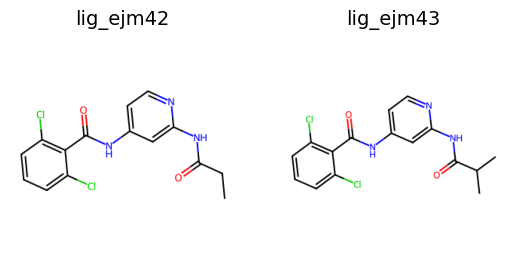

In [13]:
# checking perturbations from below
val_dict = {}
val_dict["value"] = {}
val_dict["difference"] = {}
pert = "lig_ejm42~lig_ejm43"
for eng in ["SOMD","AMBER","GROMACS"]:
    val_dict["value"][eng] = f"{ana_obj.calc_pert_dict[eng][pert][0]:.2f} ({ana_obj.calc_pert_dict[eng][pert][1]:.2f})"
    val_dict["difference"][eng] = f"{abs(ana_obj.calc_pert_dict[eng][pert][0] - ana_obj.exper_pert_dict[pert][0]):.2f}"
val_dict["value"]["experimental"] = f"{ana_obj.exper_pert_dict[pert][0]:.2f} ({ana_obj.exper_pert_dict[pert][1]:.2f})"
ana_obj.draw_perturbations([pert])

nets = []
for key in network_dict.keys():
    aj = network_dict[key]["plain"]
    if pert in aj.perturbations:
        nets.append(key)
print(pert)
print(nets)
print(
    f"difference: {max([ana_obj.calc_pert_dict[eng][pert][0] for eng in ana_obj.engines]) - min([ana_obj.calc_pert_dict[eng][pert][0] for eng in ana_obj.engines]):.2f}")

df = pd.DataFrame(val_dict)
df

In [8]:
# find the greatest difference to experimental

for eng in ana_obj.engines:
    diff_dict = {}
    for pert in ana_obj.calc_pert_dict[eng]:
        if "Intermediate" in pert:
            pass
        else:
            diff_dict[pert] = abs(ana_obj.calc_pert_dict[eng][pert][0] - ana_obj.exper_pert_dict[pert][0])

    print(eng)
    sorted_items = sorted(diff_dict.items(), key=lambda kv: (kv[1], kv[0]))

    df = pd.DataFrame(sorted_items, columns=["perturbation","mae"])
    df["results"] = df["perturbation"].map(lambda x: ana_obj.calc_pert_dict[eng][x])
    df["experimental"] = df["perturbation"].map(lambda x: ana_obj.exper_pert_dict[x])
    print(df.nlargest(5, 'mae'))

    # ana_obj.draw_perturbations([sorted_items[-1][0], sorted_items[-2][0], sorted_items[-3][0]])

AMBER
           perturbation       mae            results  \
59  lig_ejm42~lig_ejm44  3.190920  (-0.8053, 0.0857)   
55  lig_ejm42~lig_ejm49  3.049799  (-0.9978, 0.2138)   
58  lig_ejm42~lig_ejm45  2.252029   (2.4812, 0.0549)   
57  lig_ejm42~lig_ejm53  2.085294  (-0.2048, 0.0617)   
54  lig_ejm42~lig_ejm43  2.073428  (-0.5386, 0.0157)   

                                 experimental  
59   (2.385619931854591, 0.24563538912123453)  
55    (2.051998668764364, 0.2516159149963097)  
58  (0.22917136953956607, 0.2507159047726531)  
57   (1.8804937569142854, 0.2516159149963097)  
54   (1.5348284220190465, 0.2506089730379271)  
SOMD
           perturbation       mae           results  \
57  lig_ejm45~lig_ejm53  4.204278  (5.8556, 0.5767)   
56  lig_ejm45~lig_ejm55  3.583228   (-3.23, 0.4856)   
55  lig_ejm44~lig_ejm54  3.325657  (0.1838, 0.2303)   
54  lig_ejm42~lig_ejm44  2.878820  (-0.4932, 0.103)   
53  lig_ejm31~lig_ejm42  2.626723   (2.385, 1.6326)   

                                 

In [31]:
# the greatest difference between engines

# Get shared keys
keys = ana_obj.calc_pert_dict["AMBER"].keys() & ana_obj.calc_pert_dict["SOMD"].keys() & ana_obj.calc_pert_dict["GROMACS"].keys()

# Compute max difference for each key
diffs = {key: max(ana_obj.calc_pert_dict["AMBER"][key][0], ana_obj.calc_pert_dict["SOMD"][key][0], ana_obj.calc_pert_dict["GROMACS"][key][0])\
         - min(ana_obj.calc_pert_dict["AMBER"][key][0], ana_obj.calc_pert_dict["SOMD"][key][0], ana_obj.calc_pert_dict["GROMACS"][key][0])\
             for key in keys}

# Sort keys by difference in descending order
sorted_keys = sorted(diffs, key=diffs.get, reverse=True)

for key in sorted_keys:
    print(key, diffs[key])
    print("AMBER", ana_obj.calc_pert_dict["AMBER"][key], "SOMD", ana_obj.calc_pert_dict["SOMD"][key],\
        "GROMACS", ana_obj.calc_pert_dict["GROMACS"][key], "experimental", ana_obj.exper_pert_dict[key])

# ana_obj.draw_perturbations(sorted_keys[:5])
# ana_obj.draw_perturbations(sorted_keys[-5:])


lig_2aa~lig_2z nan
AMBER (nan, nan) SOMD (0.3926, 0.119) GROMACS (0.442, 0.4789) experimental (-1.0991539986370427, 0.3167064013468535)
lig_2aa~lig_2b 4.8408999999999995
AMBER (-2.0677, 0.6044) SOMD (-0.7791, 0.7634) GROMACS (2.7732, 3.1255) experimental (-1.4448193335322816, 0.26676275582866643)
lig_2p~lig_2t 4.6734
AMBER (-2.8622, 0.1286) SOMD (-0.1336, 0.6203) GROMACS (-4.807, 1.5767) experimental (-0.6549501055788536, 0.10229760030591596)
Intermediate~Intermediate_3 3.3768
AMBER (-3.6328, 0.0697) SOMD (-7.0096, 0.3673) GROMACS (-5.6649, 0.267) experimental (None, None)
lig_2p~lig_2s 2.8815999999999997
AMBER (-2.6881, 0.9885) SOMD (0.1935, 0.3831) GROMACS (0.1251, 0.31) experimental (0.09189866622583764, 0.0985968709223395)
lig_2e~lig_2r 2.8562
AMBER (-0.8058, 0.0739) SOMD (-2.5663, 0.054) GROMACS (0.2899, 1.6954) experimental (-0.09189866622583764, 0.27413777869744144)
lig_2dd~lig_2i 2.6429
AMBER (0.3599, 0.3856) SOMD (3.0028, 0.9757) GROMACS (1.6606, 0.2706) experimental (-0.10394

In [ ]:
# ligand analysis
ana_obj = network_dict["combined"]["plain"]

In [ ]:
# ana_obj.remove_perturbations(["lig_CHEMBL3402754_40~lig_CHEMBL3402755_4200"])
# ana_obj.compute_results()
# for eng in ana_obj.engines:
#     ana_obj.disconnected_ligands(eng)

In [ ]:
# for literature results
# calculate value statistics

for stats_name, stats, func in zip(["MAE (kcal/mol)", "Kendall's Rank", "R2"], ["MUE", "KTAU", "R2"], [ana_obj.calc_mae_engines, ana_obj.calc_kendalls_rank_engines, ana_obj.calc_r2_engines]):
    
    print(stats_name)

    val_dict = {}
    val_dict[protein] = {}

    res = func(pert_val="val", recalculate=False) # mae / kendalls_rank / r2
    for eng in ana_obj.engines:
        val_dict[protein][eng_dict_name[eng]] = (
                            res[0][eng]["experimental"],
                            res[1][eng]["experimental"],
                            res[2][eng]["experimental"],
                        )
        # print("cinnabar", eng, res[0][eng]["experimental"], res[1][eng]["experimental"], res[2][eng]["experimental"])

    # add the experimental values

    # normalise exper dict
    exper_dict = ana_obj.exper_val_dict

    normalised_exper_dict = {}
    avg = np.mean([val[0] for val in exper_dict.values()])
    for lig in exper_dict:
        normalised_exper_dict[lig] = (exper_dict[lig][0] - avg, exper_dict[lig][1])

    for lit_val_dict, name in zip([openfe_ligs_dict, hahn_ligs_dict, fepplus_ligs_dict], ["openfe", "hahn", "fepplus"]):  #
        x = []
        y = []
        xerr = []
        yerr = []
        for lig in ana_obj.ligands:
            if lig in lit_val_dict.keys():
                if not np.isnan(lit_val_dict[lig][0]):
                    x.append(lit_val_dict[lig][0])
                    xerr.append(lit_val_dict[lig][1])
                    y.append(normalised_exper_dict[lig][0])
                    yerr.append(normalised_exper_dict[lig][1])

        # calculate statistics 

        res = stats_engines.compute_stats(x=x, xerr=xerr, y=y, yerr=yerr, statistic=stats) # MUE, KTAU, R2
        # print("cinnabar", name, res)

        val_dict[protein][eng_dict_name[name]] = (
                            res[0],
                            res[1],
                            res[2],
                        )

    val_res = pd.DataFrame(val_dict).T.map(lambda x: x[0])
    ax = val_res.plot.bar(color=col_dict,
                            yerr=pd.DataFrame(val_dict).T.map(lambda x: x[1]),
                            xlabel = "protein",
                            ylabel=f"{stats_name}")
    ax.legend(loc='lower center', bbox_to_anchor=(
        0.5, 1.), #fancybox=True, shadow=True
        )

    df = pd.DataFrame(val_dict)
    df = df.applymap(lambda x: f"{x[0]:.2f} ({x[2][0]:.2f},{x[2][1]:.2f})")
    print(df)

In [ ]:
# plot the a/d optimal networks together w their counterpart

stats_name = "MAE"
net = "lomap"

plotting_dict = {}
for network in [f"{net}", f"{net}-a-optimal", f"{net}-d-optimal"]:
    plotting_dict[network] = {}
    aj = network_dict[network]["plain"]

    if stats_name == "MAE":
        func = aj.calc_mae_engines
    elif stats_name == "KTAU":
        func = aj.calc_kendalls_rank_engines
    elif stats_name == "R2":
        func = aj.calc_r2_engines
    else:
        print("no")
        func = None

    vals = func(pert_val="val", recalculate=False)

    for eng in aj.engines:
        data_point = (
            vals[0][eng]["experimental"],
            vals[1][eng]["experimental"],
            vals[2][eng]["experimental"],
        )

        # print(network, protein, eng, data_point)

        plotting_dict[network][eng] = data_point

# print(plotting_dict)

# fig, ax = plt.subplots(figsize=(8, 6))
# plt.xlim = ()
# plt.ylim = ()

df = pd.DataFrame(plotting_dict).applymap(lambda x: x[0]).T
df_err = pd.DataFrame(plotting_dict).applymap(lambda x: x[1]).T

# engine colours
col_dict = {
    "AMBER": ["orange", "moccasin", "oldlace"],
    "SOMD": ["darkturquoise", "paleturquoise", "azure"],
    "GROMACS": ["orchid", "plum", "pink"],
}
df.plot(
    kind="bar",
    color=col_dict,
    yerr=df_err,
    title=prot_dict_name[protein],
    xlabel="Network Method",
    ylabel=f"{stats_name}",
    legend=True,
)
# key = pipeline.analysis.set_colours()
# key.pop("experimental")
# pos.legend(key)

df = pd.DataFrame(plotting_dict)
df = df.applymap(lambda x: f"{x[0]:.2f} ({x[2][0]:.2f},{x[2][1]:.2f})")
df

In [ ]:
pd.DataFrame(plotting_dict).applymap(lambda x: x[0])

In [50]:
ana_obj.remove_ligands(["lig_ejm45"], name="AMBER")
# ana_obj.remove_perturbations(["lig_ejm46~lig_jmc23"], name="AMBER")
ana_obj._compute_dicts()
ana_obj._perturbations_dict["AMBER"]

INFO:root:removed lig_ejm45 from the cinnabar dict as no pert values
INFO:root:removed lig_ejm45 from the cinnabar dict as no pert values


['lig_ejm44~lig_ejm54',
 'lig_ejm54~lig_ejm55',
 'lig_ejm48~lig_ejm55',
 'lig_ejm43~lig_ejm46',
 'lig_ejm43~lig_ejm47',
 'lig_ejm42~lig_ejm53',
 'lig_ejm42~lig_ejm46',
 'lig_ejm42~lig_ejm47',
 'lig_ejm42~lig_ejm48',
 'lig_ejm43~lig_ejm50',
 'lig_ejm42~lig_ejm50',
 'lig_ejm44~lig_ejm55',
 'lig_ejm31~lig_ejm49',
 'lig_ejm31~lig_ejm42',
 'lig_ejm42~lig_ejm55',
 'lig_ejm42~lig_ejm44',
 'lig_jmc27~lig_jmc30',
 'lig_jmc23~lig_jmc30',
 'lig_ejm31~lig_ejm44',
 'lig_ejm42~lig_ejm43',
 'lig_ejm43~lig_ejm44',
 'lig_ejm46~lig_jmc27',
 'lig_jmc27~lig_jmc28',
 'lig_jmc23~lig_jmc28',
 'lig_jmc23~lig_jmc27']

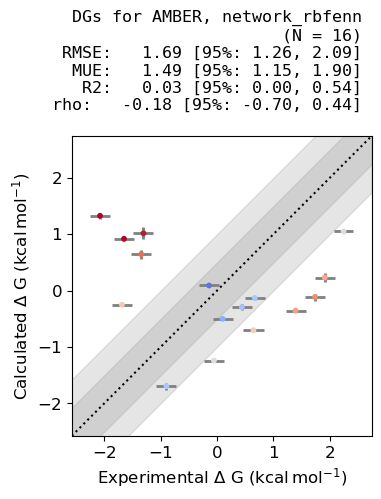

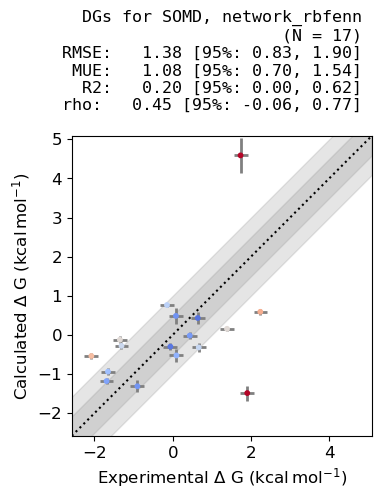

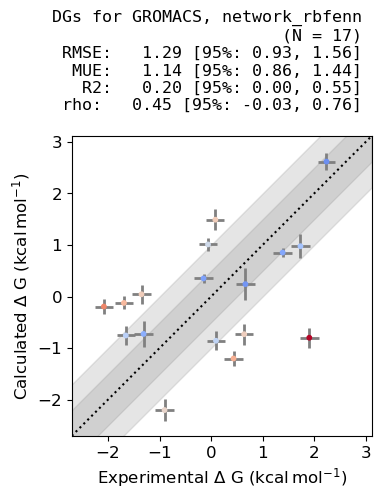

In [51]:
ana_obj.plot_scatter_dG(use_cinnabar=True)

INFO:root:outlier names for AMBER are ['lig_ejm45', 'lig_ejm49', 'lig_ejm43', 'lig_ejm46', 'lig_ejm53']


[0.08299334241172396, 1.7343157297864433, 2.239441904726749, -0.9024153595424647, 0.4362210782170912, 0.6418016230865113, 1.3886503948912043, -1.6903950097568199, -0.0596261346571314, -0.14617802712784211, 0.6661381154931227, 1.905820641636522, 0.09554456973654624, 0.0]
[2.5600725253703462, 0.20365058851589254, 1.2446839112521262, -1.529676228886424, -0.1265440890180726, -0.5530047090097566, -0.20761146497050068, -0.10486035784224532, -1.0934260677036332, 0.23637426187369445, 0.014998814472131429, -0.27765375353236843, -0.3670034305211977, 0.0]
-1.6903950097568199 2.5600725253703462


INFO:root:outlier names for SOMD are ['lig_ejm49', 'lig_ejm53', 'lig_ejm44', 'lig_ejm43', 'lig_jmc28']


[0.08299334241172396, 1.7343157297864433, 2.239441904726749, -0.9024153595424647, 0.4362210782170912, 0.6418016230865113, 1.3886503948912043, -1.6903950097568199, -0.0596261346571314, -0.14617802712784211, 0.6661381154931227, 1.905820641636522, 0.09554456973654624, -1.349718501276275]
[0.4862341624201991, 4.5899279345478865, 0.5911545325826543, -1.3123101047386716, -0.017318439267470332, 0.4325115397445655, 0.15657565627775535, -1.1798515654356763, -0.29914381837471016, 0.763947410127703, -0.31993693674616797, -1.48656528272247, -0.524609743235615, -0.12325187895802425]
-1.6903950097568199 4.5899279345478865


INFO:root:outlier names for GROMACS are ['lig_ejm49', 'lig_ejm55', 'lig_ejm46', 'lig_ejm45', 'lig_jmc28']


[0.08299334241172396, 1.7343157297864433, 2.239441904726749, -0.9024153595424647, 0.4362210782170912, 0.6418016230865113, 1.3886503948912043, -1.6903950097568199, -0.0596261346571314, -0.14617802712784211, 0.6661381154931227, 1.905820641636522, 0.09554456973654624, -1.349718501276275]
[1.4910750549518563, 0.9771112955163698, 2.6184560278141387, -2.201961348359743, -1.2018305274655887, -0.7303239598253247, 0.8540252376191372, -0.1238555351651347, 1.0112888455943017, 0.35148470758358835, 0.24099363836202323, -0.7987645131289437, -0.8577163971266106, 0.04425180367379373]
-2.201961348359743 2.6184560278141387


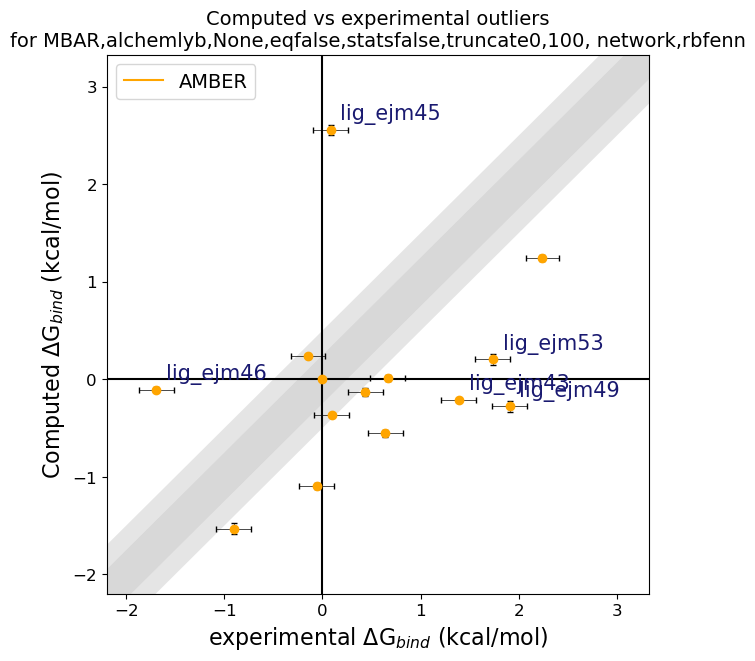

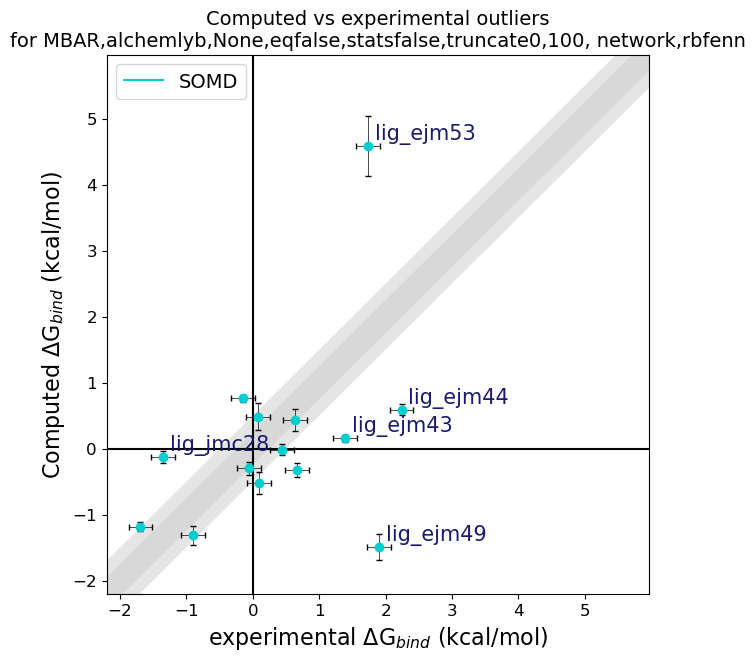

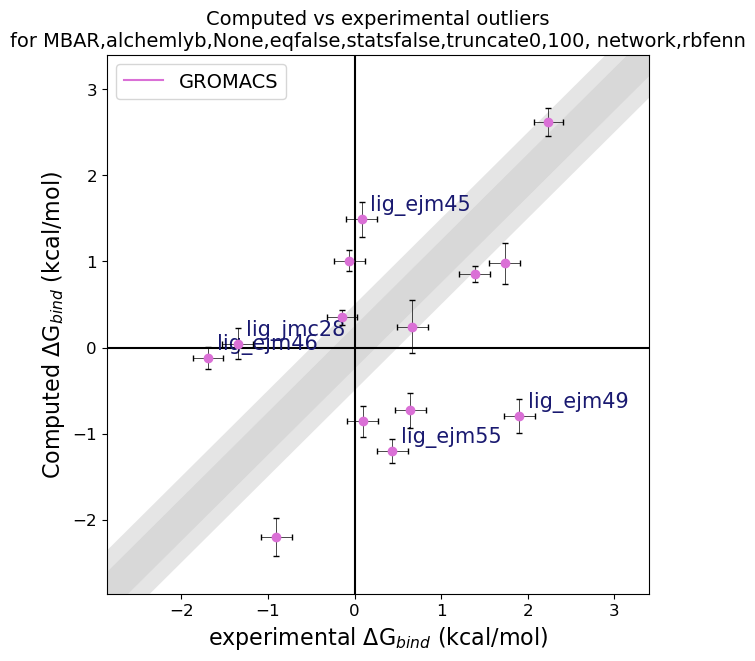

In [28]:
for eng in ana_obj.engines:
    ana_obj.plot_outliers(engines=[eng], pert_val="val", no_outliers=5)

In [15]:
# ligand analysis
ana_obj = network_dict["rbfenn"]["plain"]

SOMD lig_2k ['lig_2k~lig_2q', 'lig_2k~lig_2m', 'lig_2k~lig_2l', 'lig_2j~lig_2k', 'lig_2k~lig_2u', 'lig_2gg~lig_2k', 'lig_2a~lig_2k', 'lig_2k~lig_2a']
AMBER lig_2k ['lig_2k~lig_2q', 'lig_2k~lig_2m', 'lig_2k~lig_2l', 'lig_2j~lig_2k', 'lig_2k~lig_2u', 'lig_2gg~lig_2k', 'lig_2a~lig_2k', 'lig_2k~lig_2a']
GROMACS lig_2k ['lig_2k~lig_2q', 'lig_2k~lig_2m', 'lig_2k~lig_2l', 'lig_2j~lig_2k', 'lig_2k~lig_2u', 'lig_2gg~lig_2k', 'lig_2a~lig_2k', 'lig_2k~lig_2a']


,value,difference
SOMD,2.23 (0.05),2.11
AMBER,1.97 (0.09),1.85
GROMACS,1.23 (0.07),1.11
experiemental,0.12 (0.10),NaN


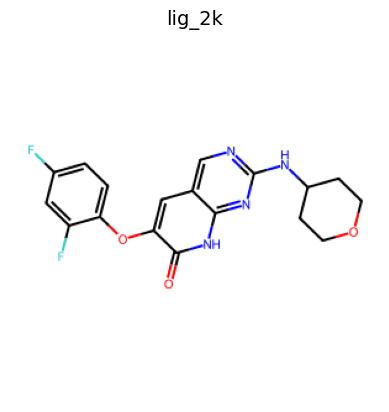

In [13]:
# checking ligands from below
val = "lig_2k"

val_dict = {}
val_dict["value"] = {}
val_dict["difference"] = {}

for eng in ["SOMD", "AMBER", "GROMACS"]:
    val_dict["value"][eng] = f"{ana_obj.cinnabar_calc_val_dict[eng][val][0]:.2f} ({ana_obj.cinnabar_calc_val_dict[eng][val][1]:.2f})"
    val_dict["difference"][eng] = f"{abs(ana_obj.cinnabar_calc_val_dict[eng][val][0] - ana_obj.normalised_exper_val_dict[val][0]):.2f}"
    perts = []
    for pert in ana_obj._perturbations_dict[eng]:
        if val in pert:
            perts.append(pert)
    print(eng, val, perts)
val_dict["value"][
    "experiemental"] = f"{ana_obj.normalised_exper_val_dict[val][0]:.2f} ({ana_obj.normalised_exper_val_dict[val][1]:.2f})"
ana_obj.draw_ligands([val])

df = pd.DataFrame(val_dict)
df

                                                                                                                                  0
combined  [lig_2k~lig_2q, lig_2k~lig_2m, lig_2k~lig_2l, lig_2j~lig_2k, lig_2k~lig_2u, lig_2gg~lig_2k, lig_2a~lig_2k, lig_2k~lig_2a]
lomap                                                                  [lig_2k~lig_2q, lig_2k~lig_2m, lig_2k~lig_2l, lig_2j~lig_2k]
rbfenn                                                                               [lig_2k~lig_2u, lig_2gg~lig_2k, lig_2a~lig_2k]
flare                                                                                                [lig_2j~lig_2k, lig_2k~lig_2a]


,combined,lomap,rbfenn,flare
SOMD,2.23 (0.05),2.12 (0.13),1.65 (0.11),1.54 (0.09)
AMBER,1.97 (0.09),2.51 (0.17),0.60 (0.13),1.96 (0.19)
GROMACS,1.23 (0.07),1.08 (0.20),0.91 (0.13),0.65 (0.15)
experimental,0.12 (0.10),0.12 (0.10),0.12 (0.10),0.12 (0.10)


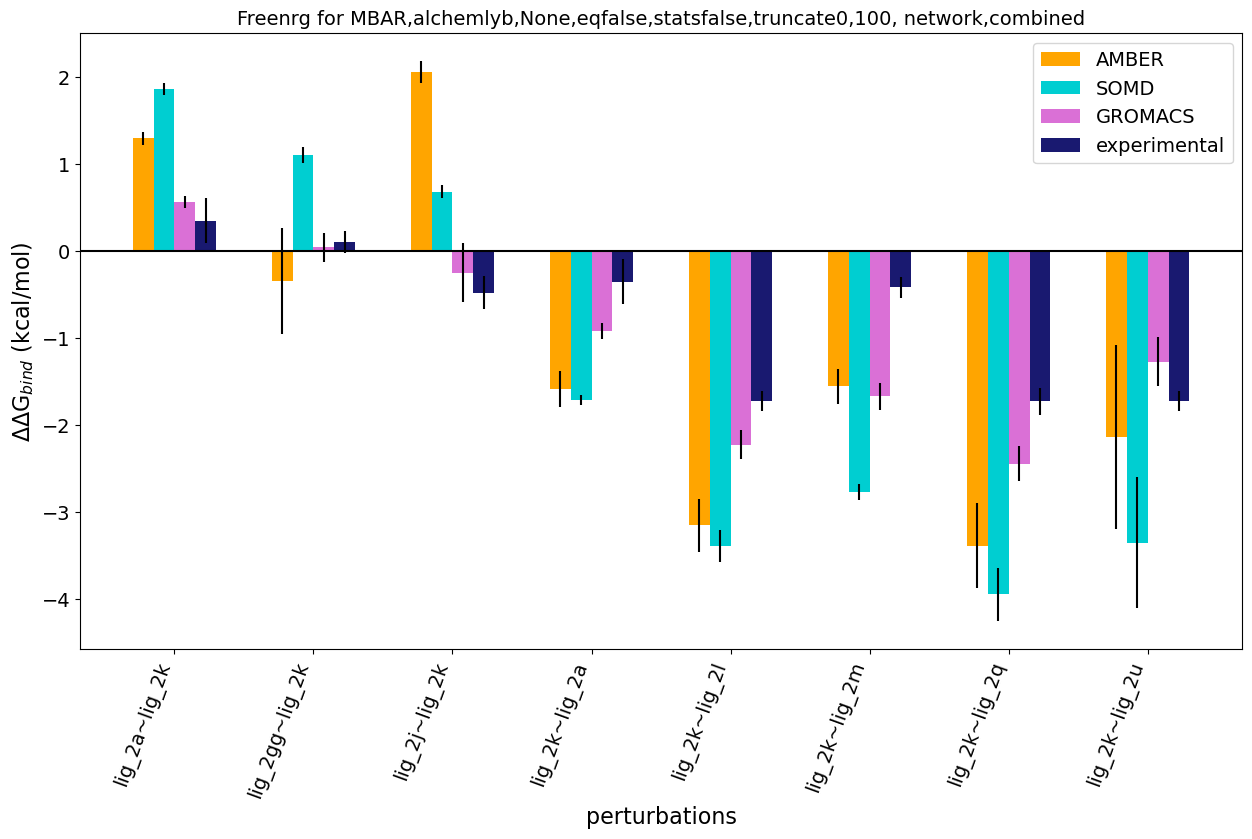

In [14]:
aj_dict = {}
val_dict = {}

for net in network_dict:
    aj = network_dict[net]["plain"]
    perts = []
    for pert in aj.perturbations:
        if val in pert:
            perts.append(pert)
    aj_dict[net] = [perts]

    val_dict[net] = {}
    for eng in ["SOMD", "AMBER", "GROMACS"]:
        val_dict[net][
            eng] = f"{aj.cinnabar_calc_val_dict[eng][val][0]:.2f} ({aj.cinnabar_calc_val_dict[eng][val][1]:.2f})"
    val_dict[net][
        "experimental"] = f"{aj.normalised_exper_val_dict[val][0]:.2f} ({aj.normalised_exper_val_dict[val][1]:.2f})"

df_perts = pd.DataFrame(aj_dict).T
plot_perts = list(set(flatten_comprehension(df_perts[0])))
ana_obj.plot_bar_ddG(values=plot_perts
                     )

pd.set_option('display.max_colwidth', None)
print(df_perts)

df = pd.DataFrame(val_dict)
df


In [15]:
df_perts

,0
combined,"[lig_2k~lig_2q, lig_2k~lig_2m, lig_2k~lig_2l, lig_2j~lig_2k, lig_2k~lig_2u, lig_2gg~lig_2k, lig_2a~lig_2k, lig_2k~lig_2a]"
lomap,"[lig_2k~lig_2q, lig_2k~lig_2m, lig_2k~lig_2l, lig_2j~lig_2k]"
rbfenn,"[lig_2k~lig_2u, lig_2gg~lig_2k, lig_2a~lig_2k]"
flare,"[lig_2j~lig_2k, lig_2k~lig_2a]"


In [16]:
# find the greatest difference to experimental

for eng in ana_obj.engines:
    diff_dict = {}
    for val in ana_obj.cinnabar_calc_val_dict[eng]:
        if "Intermediate" not in val:
            diff_dict[val] = abs(ana_obj.cinnabar_calc_val_dict[eng][val][0] - ana_obj.normalised_exper_val_dict[val][0])

    print(eng)
    sorted_items = sorted(diff_dict.items(), key=lambda kv: (kv[1], kv[0]))

    df = pd.DataFrame(sorted_items, columns=["ligand","mae"])
    df["results"] = df["ligand"].map(lambda x: ana_obj.cinnabar_calc_val_dict[eng][x])
    df["experimental"] = df["ligand"].map(lambda x: ana_obj.normalised_exper_val_dict[x])
    print(df.nlargest(5, 'mae'))

    for lig in [sorted_items[-1][0], sorted_items[-2][0], sorted_items[-3][0]]:
        perts = []
        for pert in ana_obj._perturbations_dict[eng]:
            if lig in pert:
                perts.append(pert)
        print(lig, perts)


    # ana_obj.draw_ligands([sorted_items[-1][0], sorted_items[-2][0], sorted_items[-3][0]])

AMBER
     ligand       mae                                       results  \
33   lig_2f  2.226337  (-0.02456738666301117, 0.044980717033014025)   
32   lig_2k  1.850023      (1.967310401218345, 0.09207794418554205)   
31  lig_2dd  1.411560    (-0.6852040187907562, 0.08145126513799836)   
30   lig_2n  1.343935    (-2.536548560345336, 0.048816616630524105)   
29  lig_2ff  1.206267       (0.4268818079827088, 0.060360136495378)   

                                  experimental  
33    (2.201769466072978, 0.21176772654822604)  
32   (0.1172870511565769, 0.09936021293021031)  
31   (0.7263559641277322, 0.23846451103250474)  
30  (-1.1926131600011303, 0.14904031939531548)  
29   (-0.779385651286665, 0.08942419163718929)  
lig_2f ['lig_2c~lig_2f', 'lig_2ff~lig_2gg', 'lig_2e~lig_2f', 'lig_2f~lig_2g', 'lig_2ff~lig_2j', 'lig_2ff~lig_2h', 'lig_2ff~lig_2hh', 'lig_2f~lig_2gg', 'lig_2ff~lig_2g', 'lig_2f~lig_2d', 'lig_2ff~lig_2a']
lig_2k ['lig_2k~lig_2q', 'lig_2k~lig_2m', 'lig_2k~lig_2l', 'lig_2j~li

In [36]:
# ligand analysis
ana_obj = network_dict["rbfenn"]["plain"]

In [24]:
# the greatest difference between engines

# Get shared keys
keys = ana_obj.cinnabar_calc_val_dict["AMBER"].keys() & ana_obj.cinnabar_calc_val_dict["SOMD"].keys() & ana_obj.cinnabar_calc_val_dict["GROMACS"].keys()

# Compute max difference for each key
diffs = {key: max(ana_obj.cinnabar_calc_val_dict["AMBER"][key][0], ana_obj.cinnabar_calc_val_dict["SOMD"][key][0], ana_obj.cinnabar_calc_val_dict["GROMACS"][key][0])\
         - min(ana_obj.cinnabar_calc_val_dict["AMBER"][key][0], ana_obj.cinnabar_calc_val_dict["SOMD"][key][0], ana_obj.cinnabar_calc_val_dict["GROMACS"][key][0])\
             for key in keys}

# Sort keys by difference in descending order
sorted_keys = sorted(diffs, key=diffs.get, reverse=True)

for key in sorted_keys:
    print(key, diffs[key])
    if "Intermediate" in key:
        print("AMBER", ana_obj.cinnabar_calc_val_dict["AMBER"][key], "SOMD", ana_obj.cinnabar_calc_val_dict["SOMD"][key],
              "GROMACS", ana_obj.cinnabar_calc_val_dict["GROMACS"][key])
    else:
        print("AMBER", ana_obj.cinnabar_calc_val_dict["AMBER"][key], "SOMD", ana_obj.cinnabar_calc_val_dict["SOMD"][key],\
            "GROMACS", ana_obj.cinnabar_calc_val_dict["GROMACS"][key], "experimental", ana_obj.normalised_exper_val_dict[key])

for lig in sorted_keys[:3]:
    perts = []
    for pert in ana_obj._perturbations_dict[eng]:
        if lig in pert:
            perts.append(pert)
    print(lig, perts)
    
# ana_obj.draw_ligands(sorted_keys[:3])

for lig in sorted_keys[-3:]:
    perts = []
    for pert in ana_obj._perturbations_dict[eng]:
        if lig in pert:
            perts.append(pert)
    print(lig, perts)

# ana_obj.draw_ligands(sorted_keys[-3:])

lig_2c 2.456401457947581
AMBER (-2.916699847487905, 0.20670944511400238) SOMD (-2.2347515875986517, 0.5194530277465756) GROMACS (-4.6911530455462325, 0.27603386707502303) experimental (0.20918571738241631, 0.2838863226577438)
lig_2s 2.3556840766828557
AMBER (-2.9995381696233423, 0.9781406675564338) SOMD (-1.1102920265253395, 0.20861652982644457) GROMACS (-0.6438540929404868, 0.27941486399897963) experimental (-0.44576438819643904, 0.08516589679732313)
lig_2ff 2.2528716951140524
AMBER (-1.6615407917882123, 0.19773840779115479) SOMD (0.59133090332584, 0.1486978053408267) GROMACS (0.3435471079000032, 0.21217912435476974) experimental (-0.779385651286665, 0.08942419163718929)
lig_2gg 2.1567186851220375
AMBER (-0.7607653062853004, 0.16577916682482335) SOMD (1.1000886109884451, 0.14813554154120953) GROMACS (1.395953378836737, 0.16556134656534105) experimental (0.008593998927688418, 0.07948817034416826)
lig_2g 2.0971521935008877
AMBER (0.717097908844714, 0.14221975365098194) SOMD (-0.25266039

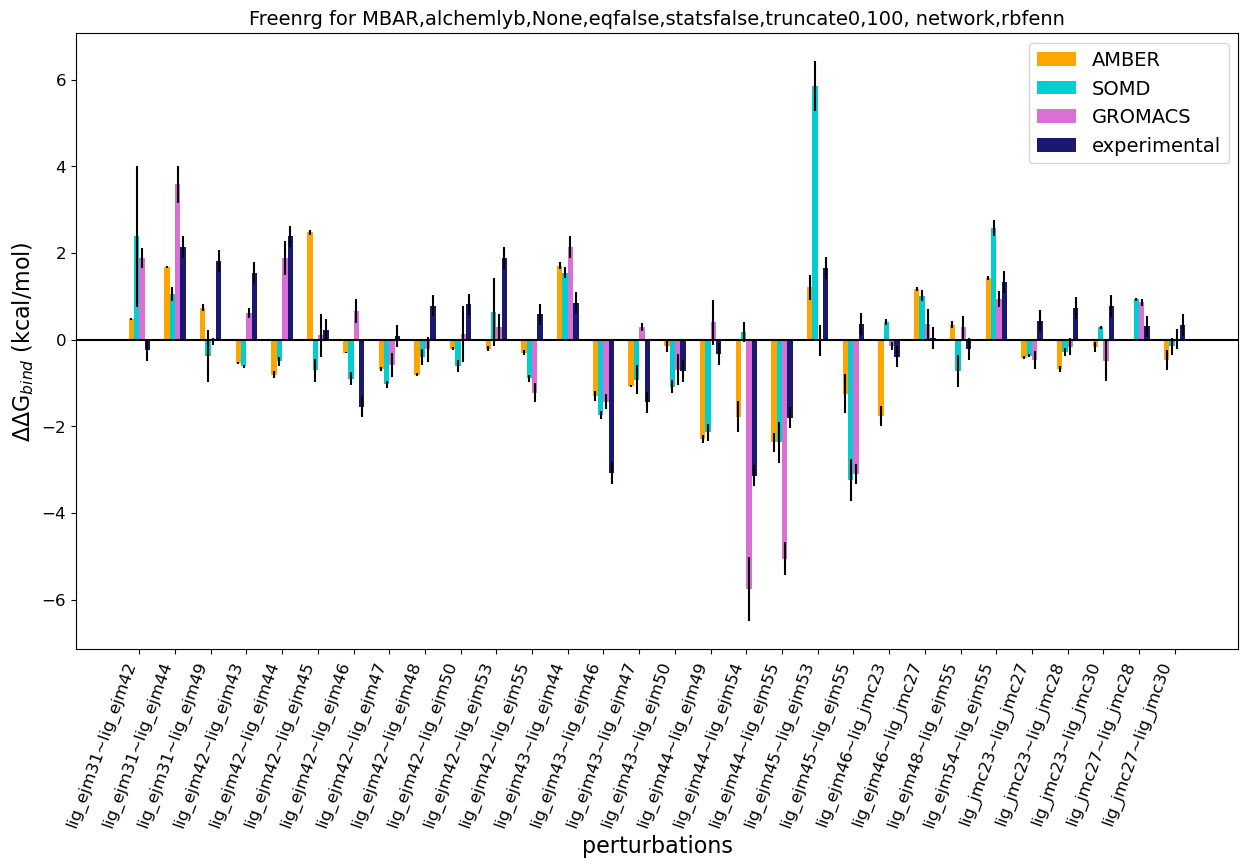

In [37]:
ana_obj.plot_bar_ddG()

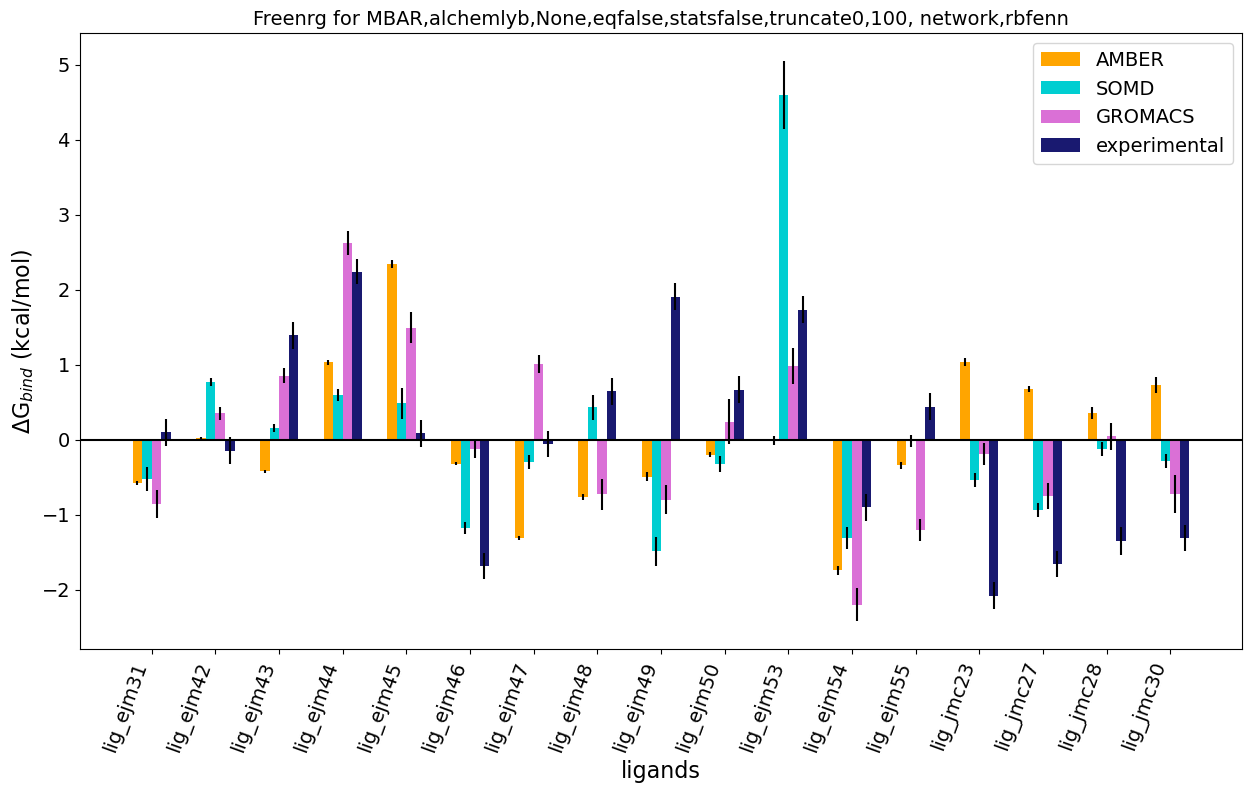

In [16]:
ana_obj.plot_bar_dG()

In [ ]:
# investigating different network analysis methods:
network = "combined"
ana_obj = network_dict[network]["plain"]


In [46]:
# get the cinnabar stats into a dict
net_ana_method_dict = {"method": [], "engine": [], "protein": [], "value": []}

for eng in ["AMBER", "SOMD", "GROMACS"]:
        
        dg_list = []

        for key in ana_obj.cinnabar_calc_val_dict[eng].keys():
            value = abs(
                abs(
                    ana_obj.cinnabar_calc_val_dict[eng][key][0]
                    - ana_obj.cinnabar_exper_val_dict[eng][key][0]
                )
            )
            dg_list.append(value)
            if value > 5:
                print(protein, eng, key, value)

        net_ana_method_dict["method"].append(
            ["cinnabar" for l in range(0, len(dg_list))]
        )
        net_ana_method_dict["engine"].append(
            [eng_dict_name[eng] for l in range(0, len(dg_list))]
        )
        net_ana_method_dict["protein"].append([prot_dict_name[protein] for val in dg_list])
        net_ana_method_dict["value"].append([val for val in dg_list])

# also want to compare fwf and cinnabar
fwf_path = (
    "/home/anna/Documents/september_2022_workshops/freenrgworkflows/networkanalysis"
)

for eng in ana_obj.engines:
    print(eng)
    dg_list = []

    # add path for fwf
    ana_obj._add_fwf_path(fwf_path)
    ana_obj._get_exp_fwf()

    try:
        fwf_dict = ana_obj._get_ana_fwf(engine=eng, use_repeat_files=True)
    except:
        print(f"{protein} {eng} did not fwf w repeat files, tring w out")
        # try:
        #     fwf_dict = ana_obj._get_ana_fwf(engine=eng, use_repeat_files=False)
        # except:
        #     print("non repeat files also failed")

    try:
        di2 = {}
        for di in ana_obj._fwf_computed_DGs[eng]:
            di2[[k for k in di.keys()][0]] = di[[k for k in di.keys()][0]]
        # experimental computed normally outside of fwf and normalised
        for key in di2.keys():
            value = abs(di2[key] - ana_obj.normalised_exper_val_dict[key][0])
            dg_list.append(value)
            if value > 5:
                print(protein, eng, key, value)
    except:
        print("did not fwf at all")

    net_ana_method_dict["method"].append(["fen" for l in range(0, len(dg_list))])
    net_ana_method_dict["engine"].append(
        [eng_dict_name[eng] for l in range(0, len(dg_list))]
    )
    net_ana_method_dict["protein"].append([prot_dict_name[protein] for val in dg_list])
    net_ana_method_dict["value"].append([val for val in dg_list])

AMBER


ERROR:root:lig_ejm42~lig_ejm49 was dropped as not in perturbations for the AMBER
ERROR:root:lig_ejm31~lig_ejm48 was dropped as not in perturbations for the AMBER
ERROR:root:lig_ejm31~lig_ejm53 was dropped as not in perturbations for the AMBER
ERROR:root:lig_ejm31~lig_ejm47 was dropped as not in perturbations for the AMBER
ERROR:root:lig_ejm31~lig_jmc23 was dropped as not in perturbations for the AMBER
ERROR:root:lig_ejm31~lig_ejm46 was dropped as not in perturbations for the AMBER
ERROR:root:lig_ejm44~lig_ejm45 was dropped as not in perturbations for the AMBER
ERROR:root:lig_ejm31~lig_ejm45 was dropped as not in perturbations for the AMBER
ERROR:root:lig_jmc28~lig_jmc30 was dropped as not in perturbations for the AMBER
ERROR:root:lig_ejm46~lig_jmc30 was dropped as not in perturbations for the AMBER
ERROR:root:lig_ejm42~lig_ejm54 was dropped as not in perturbations for the AMBER
ERROR:root:lig_ejm31~lig_ejm50 was dropped as not in perturbations for the AMBER
ERROR:root:lig_ejm46~lig_jmc

SOMD


ERROR:root:lig_ejm48~lig_ejm54 was dropped as not in perturbations for the SOMD
ERROR:root:{'/backup/tyk2/outputs_extracted/analysis/files/fwf_SOMD_file_1.csv': 30, '/backup/tyk2/outputs_extracted/analysis/files/fwf_SOMD_file_2.csv': 30, '/backup/tyk2/outputs_extracted/analysis/files/fwf_SOMD_file_0.csv': 29}
INFO:root:/backup/tyk2/outputs_extracted/analysis/files/fwf_SOMD_file_1.csv
ERROR:root:{'lig_ejm49'}
ERROR:root:['lig_ejm31', 'lig_ejm49', 'lig_ejm42', 'lig_ejm47', 'lig_ejm54', 'lig_ejm55', 'lig_ejm43', 'lig_ejm44', 'lig_ejm50', 'lig_jmc23', 'lig_jmc28', 'lig_jmc27', 'lig_ejm45', 'lig_ejm53', 'lig_ejm48', 'lig_ejm46', 'lig_jmc30']
/home/anna/Documents/september_2022_workshops/freenrgworkflows/networkanalysis/networkanalysis.py:136: UserWarning: Provided network is disconnected. Doing analysis on subgraph.
  warnings.warn('Provided network is disconnected. Doing analysis on subgraph.') # FIXME
INFO:root:/backup/tyk2/outputs_extracted/analysis/files/fwf_SOMD_file_2.csv
INFO:root:/b

GROMACS


ERROR:root:lig_ejm42~lig_ejm49 was dropped as not in perturbations for the GROMACS
ERROR:root:lig_ejm31~lig_ejm48 was dropped as not in perturbations for the GROMACS
ERROR:root:lig_ejm31~lig_ejm53 was dropped as not in perturbations for the GROMACS
ERROR:root:lig_ejm31~lig_ejm47 was dropped as not in perturbations for the GROMACS
ERROR:root:lig_ejm31~lig_jmc23 was dropped as not in perturbations for the GROMACS
ERROR:root:lig_ejm31~lig_ejm46 was dropped as not in perturbations for the GROMACS
ERROR:root:lig_ejm44~lig_ejm45 was dropped as not in perturbations for the GROMACS
ERROR:root:lig_ejm31~lig_ejm45 was dropped as not in perturbations for the GROMACS
ERROR:root:lig_jmc28~lig_jmc30 was dropped as not in perturbations for the GROMACS
ERROR:root:lig_ejm46~lig_jmc30 was dropped as not in perturbations for the GROMACS
ERROR:root:lig_ejm42~lig_ejm54 was dropped as not in perturbations for the GROMACS
ERROR:root:lig_ejm31~lig_ejm50 was dropped as not in perturbations for the GROMACS
ERRO

In [ ]:
ana_obj.analyse_mbarnet(
    compute_missing=True,
    write_xml=True,
    run_xml_py=True,
    use_experimental=True,
    overwrite=True,
    engines=["SOMD"],
    normalise=True,
)
ana_obj._mbarnet_computed_DGs

In [ ]:
# mbarnet

# compute all first
for eng in ana_obj.engines:
    try:
        ana_obj.analyse_mbarnet(
            compute_missing=False,
            write_xml=False,
            run_xml_py=False,
            use_experimental=True,
            overwrite=False,
            engines=[eng],
            normalise=True,
        )
    except Exception as e:
        print(e)
        print(f"failed for {eng}")

for eng in ana_obj.engines:
    dg_list = []
    print(eng)

    try:
        for key in ana_obj._mbarnet_computed_DGs[eng].keys():
            value = abs(
                ana_obj._mbarnet_computed_DGs[eng][key][0]
                - ana_obj.normalised_exper_val_dict[key][0]
            )
            dg_list.append(value)
            if value > 5:
                print(eng, key, value)
    except:
        pass

    net_ana_method_dict["method"].append(
        ["MBARNet" for l in range(0, len(dg_list))]
    )
    net_ana_method_dict["engine"].append(
        [eng_dict_name[eng] for l in range(0, len(dg_list))]
    )
    net_ana_method_dict["protein"].append([prot_dict_name[protein] for val in dg_list])
    net_ana_method_dict["value"].append([val for val in dg_list])

In [ ]:
pd.DataFrame(df_dict)

INFO:root:loading existing files for the MAE....
INFO:root:loading existing files for the MAE....
INFO:root:loading existing files for the MAE....


cinnabar
fen


INFO:root:loading existing files for the Kendalls....
INFO:root:loading existing files for the Kendalls....
INFO:root:loading existing files for the Kendalls....


mbarnet
'AMBER'
'SOMD'
'GROMACS'
MAE (kcal/mol)
cinnabar
                     tyk2
AMBER    1.53 (1.19,1.88)
SOMD     1.08 (0.71,1.51)
GROMACS  1.14 (0.87,1.43)
fen
                     tyk2
AMBER    1.37 (1.03,1.72)
SOMD     1.21 (0.98,1.46)
GROMACS  1.29 (0.89,1.69)
mbarnet
                     tyk2
AMBER    0.00 (0.00,0.00)
SOMD     0.00 (0.00,0.00)
GROMACS  0.00 (0.00,0.00)
cinnabar
fen


INFO:root:loading existing files for the R2....
INFO:root:loading existing files for the R2....
INFO:root:loading existing files for the R2....


mbarnet
'AMBER'
'SOMD'
'GROMACS'
Kendall's Rank
cinnabar
                       tyk2
AMBER    -0.13 (-0.51,0.27)
SOMD      0.29 (-0.12,0.65)
GROMACS   0.22 (-0.14,0.57)
fen
                       tyk2
AMBER    -0.06 (-0.48,0.32)
SOMD       0.34 (0.05,0.61)
GROMACS   0.28 (-0.16,0.61)
mbarnet
                     tyk2
AMBER    0.00 (0.00,0.00)
SOMD     0.00 (0.00,0.00)
GROMACS  0.00 (0.00,0.00)
cinnabar
fen
mbarnet
'AMBER'
'SOMD'
'GROMACS'
R2
cinnabar
                     tyk2
AMBER    0.01 (0.00,0.37)
SOMD     0.20 (0.00,0.60)
GROMACS  0.20 (0.00,0.56)
fen
                     tyk2
AMBER    0.00 (0.00,0.34)
SOMD     0.24 (0.04,0.48)
GROMACS  0.06 (0.00,0.36)
mbarnet
                     tyk2
AMBER    0.00 (0.00,0.00)
SOMD     0.00 (0.00,0.00)
GROMACS  0.00 (0.00,0.00)


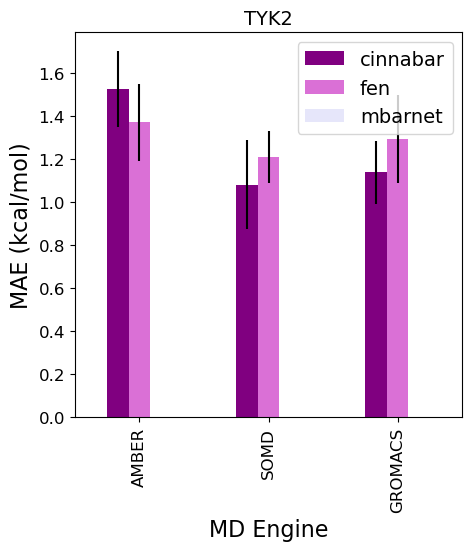

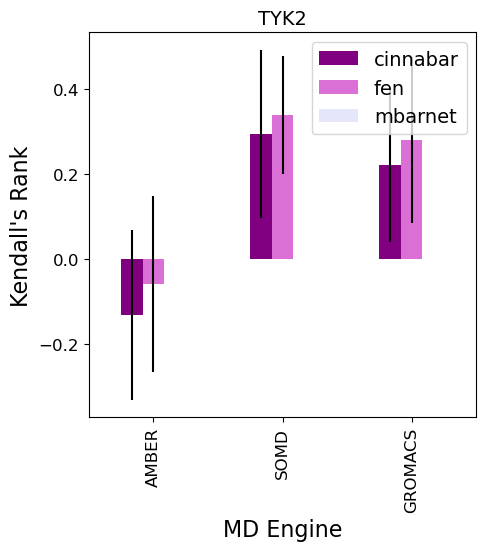

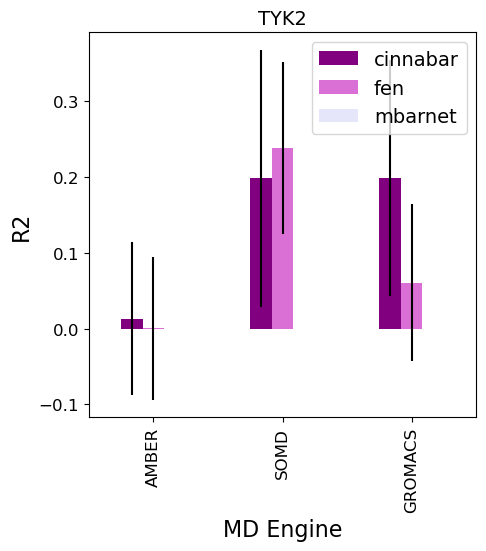

In [47]:
for stats_name, stats, func in zip(["MAE (kcal/mol)", "Kendall's Rank", "R2"], ["MUE", "KTAU", "R2"], [ana_obj.calc_mae_engines, ana_obj.calc_kendalls_rank_engines, ana_obj.calc_r2_engines]):
        
    df_dict = {}

    df_dict["cinnabar"] = {}
    df_dict["fen"] = {}
    df_dict["mbarnet"] = {}

    print("cinnabar")
    df_dict["cinnabar"][protein] = {}

    for eng in ana_obj.engines:
        try:
            df, df_err, df_ci = func(engines=[eng], pert_val="val", recalculate=False)
            df_dict["cinnabar"][protein][eng] = (
                df[eng]["experimental"],
                df_err[eng]["experimental"],
                df_ci[eng]["experimental"]
            )
            # print(stats_name, eng, df[eng]["experimental"], df_ci[eng]["experimental"])
        except:
            df_dict["cinnabar"][protein][eng] = (0, 0, (0, 0))


    df_dict["fen"][protein] = {}

    print("fen")
    for eng in ana_obj.engines:
        try:
            df, df_err, df_ci = ana_obj._get_stats_fwf(engines=[eng], statistic=stats)
            df_dict["fen"][protein][eng] = (
                df[eng]["experimental"],
                df_err[eng]["experimental"],
                df_ci[eng]["experimental"]
            )
            # print(stats_name, eng, df[eng]["experimental"], df_ci[eng]["experimental"])
        except:
            print("ooft")
            df_dict["fen"][protein][eng] = (0, 0, (0, 0))

    df_dict["mbarnet"][protein] = {}
    print("mbarnet")
    for eng in ana_obj.engines:
        try:
            print(
                protein,
                eng,
                len(ana_obj._perturbations_dict[eng]),
                len(ana_obj._mbarnet_computed_DGs[eng]),
            )
        except Exception as e:
            print(e)

    for eng in ana_obj.engines:
        # try:
        #     df, df_err, df_ci = ana_obj._get_stats_mbarnet(
        #         engines=[eng], statistic=stats
        #     )
        #     df_dict["mbarnet"][protein][eng] = (
        #         df[eng]["experimental"],
        #         df_err[eng]["experimental"],
        #         df_ci[eng]["experimental"]
        #     )
        #     print(stats_name, eng, df[eng]["experimental"], df_ci[eng]["experimental"])
        # except:
        #     print("oop")
        df_dict["mbarnet"][protein][eng] = (0, 0, (0,0))

    print(stats_name)
    print("cinnabar")
    df = pd.DataFrame(df_dict["cinnabar"])
    df = df.applymap(lambda x: f"{x[0]:.2f} ({x[2][0]:.2f},{x[2][1]:.2f})")
    print(df)
    print("fen")
    df = pd.DataFrame(df_dict["fen"])
    df = df.applymap(lambda x: f"{x[0]:.2f} ({x[2][0]:.2f},{x[2][1]:.2f})")
    print(df)
    print("mbarnet")
    df = pd.DataFrame(df_dict["mbarnet"])
    df = df.applymap(lambda x: f"{x[0]:.2f} ({x[2][0]:.2f},{x[2][1]:.2f})")
    print(df)

    # compare stats
    fig, ax = plt.subplots(figsize=(5, 5), sharex=True, sharey=True)
    plt.xlim = ()
    plt.ylim = ()

    df_cinnabar = (
        pd.DataFrame(df_dict["cinnabar"])
        .applymap(lambda x: x[0])
        .rename({protein: "cinnabar"}, axis=1)
    )
    df_fen = (
        pd.DataFrame(df_dict["fen"])
        .applymap(lambda x: x[0])
        .rename({protein: "fen"}, axis=1)
    )
    df_mbarnet = (
        pd.DataFrame(df_dict["mbarnet"])
        .applymap(lambda x: x[0])
        .rename({protein: "mbarnet"}, axis=1)
    )
    df = reduce(
        lambda left, right: pd.merge(left, right, left_index=True, right_index=True),
        [df_cinnabar, df_fen, df_mbarnet],
    )

    df_cinnabar = (
        pd.DataFrame(df_dict["cinnabar"])
        .applymap(lambda x: x[1])
        .rename({protein: "cinnabar"}, axis=1)
    )
    df_fen = (
        pd.DataFrame(df_dict["fen"])
        .applymap(lambda x: x[1])
        .rename({protein: "fen"}, axis=1)
    )
    df_mbarnet = (
        pd.DataFrame(df_dict["mbarnet"])
        .applymap(lambda x: x[1])
        .rename({protein: "mbarnet"}, axis=1)
    )
    df_err = reduce(
        lambda left, right: pd.merge(left, right, left_index=True, right_index=True),
        [df_cinnabar, df_fen, df_mbarnet],
    )

    # df_lower = df_err.applymap(lambda x: x[0])
    # df_upper = df_err.applymap(lambda x: x[1])
    # df_err = (df_upper - df_lower)/2

    df.plot(
        kind="bar",
        color=["purple", "orchid", "lavender"],
        yerr=df_err,
        title=prot_dict_name[protein],
        ax=ax,
        xlabel="MD Engine",
        ylabel=f"{stats_name}",
    )

In [ ]:
plotting_dict = {
    "method": flatten_comprehension(net_ana_method_dict["method"]),
    "MD engine": flatten_comprehension(net_ana_method_dict["engine"]),
    "MAE dG (kcal/mol)": flatten_comprehension(net_ana_method_dict["value"]),
    "Protein": flatten_comprehension(net_ana_method_dict["protein"]),
}

fig, ax = plt.subplots(figsize=(3.25, 3.25), dpi=500)
df = pd.DataFrame(plotting_dict)
sns.boxplot(
    df,
    x="MD engine",
    y="MAE dG (kcal/mol)",
    hue="method",
    palette=["purple", "orchid", "lavender"],
    ax=ax,
)
# modify individual font size of elements
plt.legend(fontsize=10)
plt.xlabel("MD Engine", fontsize=10)
plt.ylabel("MAE ΔG (kcal/mol)", fontsize=10)
plt.tick_params(axis="both", which="major", labelsize=10)
# ax.set_ylim(top=12)

In [ ]:
# consensus scoring
# for a single repeat for each engine
for r in [0, 1, 2]:
    print(r)
    consensus_name = f"consensus_{r}"
    pipeline.utils.validate.folder_path(
        f"{ana_obj.files_folder}/{consensus_name}", create=True
    )

    # pert_dict = {}
    # for eng in ana_obj.engines:
    #     pert_dict[eng] = []

    # for pert in ana_obj.perturbations:
    #     vals = []
    #     for eng in ana_obj.engines:
    #         try:
    #             vals.append(ana_obj.calc_repeat_pert_dict[eng][r][pert][0])
    #         except:
    #             try:
    #                 vals.append(
    #                     -ana_obj.calc_repeat_pert_dict[eng][r][
    #                         f"{pert.split('~')[1]}~{pert.split('~')[0]}"
    #                     ][0]
    #                 )
    #             except:
    #                 print(f"{pert} doesnt exist for {eng}")
    #     vals_mean = np.mean(vals)

        # threshold_from_mean = 5

        # for eng in ana_obj.engines:
        #     try:
        #         if (
        #             ana_obj.calc_pert_dict[eng][pert][0]
        #             < vals_mean + threshold_from_mean
        #         ):
        #             if (
        #                 ana_obj.calc_pert_dict[eng][pert][0]
        #                 > vals_mean - threshold_from_mean
        #             ):
        #                 pert_dict[eng].append(pert)
        #     except:
        #         print(prot, eng, pert)

    # if no threshold , use all perts
    pert_dict = ana_obj._perturbations_dict

    mod_results_files_list = []

    for eng in ana_obj.engines:
        mod_results_files = write_modified_results_files(
            results_files=ana_obj._results_repeat_files[eng][r],
            perturbations=pert_dict[eng],
            output_folder=f"{ana_obj.files_folder}/{consensus_name}",
            **{"engine": eng},
        )
        print(mod_results_files)
        mod_results_files_list.append(mod_results_files)

    mod_results_files_list = flatten_comprehension(mod_results_files_list)
    print(mod_results_files_list)

    try:
        ana_obj.compute_other_results(
            mod_results_files_list, name=f"{consensus_name}", method=None
        )
    except:
        print(f"could not for {prot}")

In [ ]:
# consensus scoring

consensus_name = f"consensus"

pipeline.utils.validate.folder_path(
    f"{ana_obj.files_folder}/{consensus_name}", create=True
)

pert_dict = ana_obj._perturbations_dict

mod_results_files_list = flatten_comprehension([ana_obj._results_repeat_files[eng] for eng in ana_obj.engines])
print(mod_results_files_list)

ana_obj.compute_other_results(
    mod_results_files_list, name=f"{consensus_name}", method=None
)


In [ ]:
# consensus scoring
# for a single repeat for each engine, excluding one the furthest away from the mean
for r in [0, 1, 2]:
    print(r)
    consensus_name = f"consensus_closest_to_mean_{r}"

    pipeline.utils.validate.folder_path(
        f"{ana_obj.files_folder}/{consensus_name}", create=True
    )

    pert_dict = {}
    for eng in ana_obj.engines:
        pert_dict[eng] = []

    for pert in ana_obj.perturbations:
        vals_ = []
        for eng in ana_obj.engines:
            try:
                vals_.append(ana_obj.calc_repeat_pert_dict[eng][r][pert][0])
            except:
                try:
                    vals_.append(
                        -ana_obj.calc_repeat_pert_dict[eng][r][
                            f"{pert.split('~')[1]}~{pert.split('~')[0]}"
                        ][0]
                    )
                except:
                    print(f"{pert} doesnt exist for {eng}")

        vals = [val for val in vals_ if str(val) != "nan"]
        if len(vals) > 2:
            max_val = ([abs(val) for val in vals / np.mean(vals)]).index(
                max([abs(val) for val in vals / np.mean(vals)])
            )
            del vals[max_val]

        vals_mean = np.mean(vals)

    mod_results_files_list = []

    for eng in ana_obj.engines:
        mod_results_files = write_modified_results_files(
            results_files=ana_obj._results_repeat_files[eng][r],
            perturbations=pert_dict[eng],
            output_folder=f"{ana_obj.files_folder}/{consensus_name}",
            **{"engine": eng},
        )
        print(mod_results_files)
        mod_results_files_list.append(mod_results_files)

    mod_results_files_list = flatten_comprehension(mod_results_files_list)
    print(mod_results_files_list)

    ana_obj.compute_other_results(
        mod_results_files_list, name=f"{consensus_name}", method=None
    )


In [ ]:
# plot the new consensus results

for stats_name, stats, func in zip(["MAE (kcal/mol)", "Kendall's Rank", "R2"], ["MUE", "KTAU", "R2"], [ana_obj.calc_mae_engines, ana_obj.calc_kendalls_rank_engines, ana_obj.calc_r2_engines]):
    print(stats_name)
    mae_dict = {}
    mae_dict[protein] = {}

    mae = func(pert_val="val", recalculate=True, engines=ana_obj.engines + ana_obj.other_results_names)
    for eng in ana_obj.engines + ana_obj.other_results_names:
        mae_dict[protein][eng] = (
            mae[0][eng]["experimental"],
            mae[1][eng]["experimental"],
            mae[2][eng]["experimental"],
        )


    df  = (
        pd.DataFrame(mae_dict)
        .applymap(lambda x: x[0]).T
        .rename(eng_dict_name, axis=0)
    )
    df_err = (
        pd.DataFrame(mae_dict)
        .applymap(lambda x: x[1]).T
        .rename(eng_dict_name, axis=0)
    )
    fig, ax = plt.subplots(#figsize=(3.25, 3.25), dpi=500
                            )
    df.plot(
        kind="bar",
        color=pipeline.analysis.set_colours(other_results_names=ana_obj.other_results_names),
        yerr=df_err,
        ax=ax,
        # title=engine,
        xlabel="protein system",
        ylabel=f"{stats_name}",
    )
    ax.legend(loc='lower center', bbox_to_anchor=(
        0.5, 1.), #fancybox=True, shadow=True
        )

In [ ]:
# comparing the different networks 
df_dict = {}
for stats_name, stats, func in zip(["MAE (kcal/mol)", "Kendall's Rank", "R2"], ["MUE", "KTAU", "R2"], ["x","y","z"]):

    df_dict[protein] = {}

    for net_name in network_dict.keys():
        print(net_name)

        ana_obj = network_dict[net_name]["plain"]
        func_dict = {"MUE": ana_obj.calc_mae_engines, "KTAU": ana_obj.calc_kendalls_rank_engines, "R2": ana_obj.calc_r2_engines}
        func = func_dict[stats]

        df_dict[protein][net_name] = {}
        
        df, df_err, df_ci = func(pert_val="val", recalculate=False)
        
        for eng in ana_obj.engines:
            try:
                df_dict[protein][net_name][eng] = (
                    df[eng]["experimental"],
                    df_err[eng]["experimental"],
                    df_ci[eng]["experimental"]
                )
                # print(stats_name, eng, df[eng]["experimental"], df_ci[eng]["experimental"])
            except:
                df_dict[protein][net_name][eng] = (0, 0, (0, 0))

        print(stats_name)
        print("cinnabar")
        df = pd.DataFrame(df_dict[protein])
        df = df.applymap(lambda x: f"{x[0]:.2f} ({x[2][0]:.2f},{x[2][1]:.2f})")
        print(df)

    # compare stats
    fig, ax = plt.subplots(figsize=(5, 5), sharex=True, sharey=True)
    plt.xlim = ()
    plt.ylim = ()

    df = (
        pd.DataFrame(df_dict[protein])
        .applymap(lambda x: x[0])
        )
    df_err = (
        pd.DataFrame(df_dict[protein])
        .applymap(lambda x: x[1])
        )
    # df_lower = df_err.applymap(lambda x: x[0])
    # df_upper = df_err.applymap(lambda x: x[1])
    # df_err = (df_upper - df_lower)/2

    col_dict = {
        "AMBER": plt.get_cmap("autumn"),
        "SOMD": plt.get_cmap("cool"),
        "GROMACS": plt.get_cmap("viridis"),
    }

    fig, ax = plt.subplots(figsize=(8, 6))

    df.plot(
        kind="bar",
        color=plt.cm.plasma(np.linspace(0, 1, len(df.columns))),
        yerr=df_err,
        title=prot_dict_name[protein],
        ax=ax,
        xlabel="Network generation method",
        ylabel=f"{stats_name}",
    )
    ax.legend(loc='center left', bbox_to_anchor=(
       1, .5),  # fancybox=True, shadow=True
    )

In [ ]:
# investigating which edge in the network is the most responsible

df_dict = {}
eng = "AMBER"
ana_obj = network_dict["rbfenn"]["plain"]

stats = "KTAU" # ["MUE", "KTAU", "R2"]

for pert in ana_obj._perturbations_dict[eng]:
    
    aj = copy.deepcopy(ana_obj)

    func_dict = {"MAE": aj.calc_mae_engines,
                "KTAU": aj.calc_kendalls_rank_engines, "R2": aj.calc_r2_engines}
    func = func_dict[stats]

    sem_arr = np.array([aj.calc_pert_dict[eng][p][1] for p in ana_obj._perturbations_dict[eng]])
    sem_arr = sem_arr[~np.isnan(sem_arr)]

    aj.calc_pert_dict[eng][pert] = (aj.exper_pert_dict[pert][0], np.mean(sem_arr))
    
    aj.compute_results()

    res = func(pert_val="val", engines=eng, recalculate=True)
    
    df_dict[pert] = (res[0][eng]["experimental"], res[1][eng]["experimental"])
    

df_dict

In [ ]:
df = pd.DataFrame(df_dict).T
df.sort_index()

In [ ]:
# plotting ROC to investigate TP and FP
network = "lomap"
ana_obj = network_dict[network]["plain"]

In [ ]:
from sklearn.metrics import roc_curve, auc

# if selecting the correct sign for a perturbation is better than zero 

fig, ax = plt.subplots(figsize=(8, 6))

for eng in ana_obj.engines:
    actual_results = np.array([ana_obj.normalised_exper_val_dict[val][0] for val in ana_obj.normalised_exper_val_dict])
    predicted_scores = np.array([ana_obj.cinnabar_calc_val_dict[eng][val][0] for val in ana_obj.normalised_exper_val_dict])

    binary_actual = (actual_results >= 0).astype(int)
    
    # roc curve
    fpr, tpr, thresholds = roc_curve(binary_actual, predicted_scores)

    # compute area under curve
    roc_auc = auc(fpr, tpr)

    ax.plot(fpr, tpr, color=col_dict[eng_dict_name[eng]],alpha=0.5, lw=2, label=f"{eng_dict_name[eng]} (AUC = {roc_auc:.2f})")
    ax.plot([0, 1], [0, 1], color="grey", linestyle="--")  # Random classifier line

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel("False Positive Rate (FPR)")
ax.set_ylabel("True Positive Rate (TPR)")
ax.set_title(f"ROC Curve, {network}, {prot_dict_name[protein]}")
ax.legend(loc="lower right")

In [ ]:
# for all networks, plots like hahn et al

categories = list(network_dict.keys())
data = []

for prot in categories:
    ana_obj = network_dict[prot]["plain"]
    x = np.array([ana_obj.normalised_exper_val_dict[val][0] for val in ana_obj.normalised_exper_val_dict])
    y = np.array([ana_obj.cinnabar_calc_val_dict[eng][val][0] for val in ana_obj.normalised_exper_val_dict])
    abs_error = (y - x)  # Absolute error calculation - np.abs
    for xi, yi, err in zip(x, y, abs_error):
        data.append([prot, xi, yi, err])

df = pd.DataFrame(data, columns=["Category", "Experimental dG (kcal/mol)", "Predicted dG (kcal/mol)", "Error"])

# Set up polar plot
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': 'polar'})

# Convert categories to base angles (evenly spaced)
base_angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False)
category_to_angle = {category: angle for category, angle in zip(categories, base_angles)}

# Define max angle spread per category (e.g., ±10 degrees)
max_angle_spread = np.radians(10)  

mae_thresholds = [0.5,1,2,3]
norm = matplotlib.colors.Normalize(vmin=0, vmax=len(mae_thresholds))

for i,threshold in enumerate(mae_thresholds):
    for category, angle in category_to_angle.items():
        
        ax.fill_between(
            # Need high res or you'll fill a triangle
            np.linspace(angle - threshold * max_angle_spread/2,
                        angle + threshold * max_angle_spread/2),
            -2,
            4,
            alpha=0.1,
            color=cm.Grays(norm(i), bytes=False),
        )

# Create a color mapping using the "plasma" colormap
cmap = cm.get_cmap("plasma", len(categories))
category_color_map = {cat: cmap(i / (len(categories) - 1)) for i, cat in enumerate(categories)}

# Plot each category
for category, base_angle in category_to_angle.items():
    subset = df[df["Category"] == category]
    
    r = subset["Experimental dG (kcal/mol)"]  # Radial distance
    abs_err_norm = subset["Error"] #/ subset["Absolute_Error"].max()  # Normalize error
    angles = base_angle + (abs_err_norm) * max_angle_spread/2  # Spread points in segment

    sc = ax.scatter(
        angles, r, c=category_color_map[category], cmap="plasma", edgecolors=None, alpha=0.75)

# Customize the plot
ax.set_xticks(base_angles)
ax.set_xticklabels(categories, fontsize=12)
ax.set_ylim(df["Experimental dG (kcal/mol)"].min() - 0.5, df["Experimental dG (kcal/mol)"].max() + 0.5)  # Adjust radial range
ax.set_title("Radial Error Plot (Angle = Error, Radius = Experimental ΔG)")
ax.set_xlabel("Experimental dG (kcal/mol)")
ax.text(0.68, 0.56, f'Experimental dG (kcal/mol)',
        transform=ax.transAxes,
        fontsize=10, color='black', ha='left', va='top', rotation = 21, 
         rotation_mode = 'anchor')

legend_patches = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=category_color_map[cat],
                             markersize=10, label=cat) for cat in categories]
ax.legend(handles=legend_patches, loc='lower left', bbox_to_anchor=(
        -0.3,-0.1), #fancybox=True, shadow=True
        )
